In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from matplotlib.patches import Circle
from scipy.special import gamma
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import exp, sqrt
from scipy.integrate import quad, dblquad, nquad, simps
from scipy.stats import rv_continuous
from scipy.special import gamma
from scipy.interpolate import interp1d
from scipy.integrate import quad
import scipy.optimize as optimize
import matplotlib.patches as patches
from itertools import product
from scipy.integrate import quad
import scipy.optimize as optimize
from  scipy.interpolate import interp1d
from scipy.misc import derivative
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
import glob
from unsio import *
import os
import wkbl
from wkbl.astro.halo_info import *
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d import proj3d
from matplotlib import cm
import wkbl.astro.nbody_essentials as nbe
from iminuit import Minuit, describe, Struct
import probfit
import cfalcon
CF =cfalcon.CFalcon()
from matplotlib.colors import LogNorm
from matplotlib.ticker import FormatStrFormatter
from matplotlib import rc
import datetime
from scipy.misc import derivative
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
labelsize = 30
tickssize = 19
textsize = 15
hydro = HALOCHydro()
dmo = HALOCdmo()
center_in_pot=True

# DMO

In [3]:

simname = dmo.name
pathsim = dmo.path
#path = "/media/arturo/ARTUROTECA/OUTPUTS/HaloB/output_00417"
myDMO = wkbl.Galaxy_Hound(pathsim)
zoomreg = np.where(myDMO.dm.mass==myDMO.dm.mass.min())
centro = nbe.real_center(myDMO.dm.pos3d[zoomreg],myDMO.dm.mass[zoomreg])

myDMO.center_shift(centro)
myDMO.r_virial(600,n=2.5)
myDMO.r200
myDMO.redefine(2.5)

loading Dark matter..


In [4]:
if (center_in_pot):
    myGkpc = 6.673e-11*((1e-3/myDMO.p.kpctokm)**3)*myDMO.p.msuntokg#kpc^ 3 Msun^-1 s^-2
    pos = np.array(myDMO.dm.pos3d.reshape(len(myDMO.dm.pos3d)*3),dtype=np.float32)#*myDMO.p.kpctokm
    ok, acc, Phy = CF.getGravity(pos,myDMO.dm.mass,0.190,G=myGkpc)
    center_pot = myDMO.dm.pos3d[np.where(Phy==Phy.min())]
    print center_pot
    myDMO.center_shift(center_pot)
    myDMO.r_virial(600,n=2.5)
    myDMO.r200
    myDMO.redefine(2.5)

[[-0.22047321 -0.0590058   0.03974251]]


In [5]:
pos = np.array(myDMO.dm.pos3d.reshape(len(myDMO.dm.pos3d)*3),dtype=np.float32)
phi_cord =myDMO.dm.phi

mass = myDMO.dm.mass
v = myDMO.dm.v
print len(mass)*3, len(pos)
r2 = myDMO.dm.pos3d[:,0]**2 + myDMO.dm.pos3d[:,1]**2 +myDMO.dm.pos3d[:,2]**2

13467717 13467717


In [6]:
ok,myDMO.dm.rho,_= CF.getDensity(np.array(myDMO.dm.pos3d.reshape(len(myDMO.dm.pos3d)*3),dtype=np.float32), myDMO.dm.mass)


In [7]:
def abg_logprofile(x,p_s,r_s,al,be,ga):
    x = 10**x
    power =  (be - ga) / (al)
    denominator = ((x/(r_s))**ga) * ((1 + (x / (r_s))**al)**power)
    return np.log10(10**p_s / denominator)

def abg_profile(x,po,r_s,al,be,ga):
    power =  (be - ga) / al
    denominator = ((x/r_s)**ga) * ((1 + (x / r_s)**al)**power)
    return (10**po) / denominator

## Mass fit

In [8]:
Pcrit = myDMO.dm._p.rho_crit
Mdm = myDMO.dm.mass.min()
myradiuses = myDMO.dm.r[np.argsort(myDMO.dm.r)]
tabN = np.cumsum(np.ones(len(myradiuses)))[1:]
myradiuses = myradiuses[1:]
Rp03 = np.sqrt(200/64.) * np.sqrt(4 * np.pi * Pcrit * tabN / 3. / Mdm ) * (myradiuses**1.5)/ np.log(tabN) 
val =0.6
R_P03 = myradiuses[ np.where(Rp03 > val) ][0]


print R_P03
hsml= 0.2# R_P03
print hsml,R_P03
# R array logarithmic Bining
r_p = np.logspace(np.log10(0.2*hsml),np.log10(hsml),15)
# histogram of dm particles per logarithmic bin
n_dm,r = np.histogram(myDMO.dm.r,bins=r_p)
# edges of bins
r1,r2 =r[:-1],r[1:]
# shell's volume
vol = 4.* np.pi * ((r2**3)-(r1**3)) / 3.
r_size = r_p[1:]-r_p[:-1]
# density per shell
profileDMO_in = n_dm*myDMO.dm.mass.min()/vol
# center of bins
r_in = (r_p[:-1]+r_p[1:])/2.


# R array logarithmic Bining
r_p = np.logspace(np.log10(3*hsml),np.log10(2.5*myDMO.r200),150)
# histogram of dm particles per logarithmic bin
n_dm,r = np.histogram(myDMO.dm.r,bins=r_p)
# edges of bins
r1,r2 =r[:-1],r[1:]
# shell's volume
vol = 4.* np.pi * ((r2**3)-(r1**3)) / 3.
r_size = r_p[1:]-r_p[:-1]
# density per shell
profileDMO = n_dm*myDMO.dm.mass.min()/vol
# center of bins
r = (r_p[:-1]+r_p[1:])/2.
bin_size= (r_p[:-1]-r_p[1:])/2.
rr = r


Delta_rho = (myDMO.dm.mass.min() /vol) + (4*np.pi*(r**2)* (n_dm*myDMO.dm.mass.min()) * r_size / vol**2)
Delta_rho2 = np.sqrt((myDMO.dm.mass.min()/np.sqrt(n_dm) /vol)**2 + (4*np.pi*(r**2)* (n_dm*myDMO.dm.mass.min()) * r_size / vol**2)**2)
Delta_rho3 =(4*np.pi*(r**2)* (n_dm*myDMO.dm.mass.min()) * r_size / vol**2)
Delta_rho4 =(myDMO.dm.mass.min() /vol)

# extra estatistics from Cfalcon density
mean = std = n = stdlog = np.array([])
for i in range(len(r_p)-1):
    shell = np.where((myDMO.dm.r > r_p[i])&(myDMO.dm.r < r_p[i+1])&(myDMO.dm.r > hsml))
    n = np.append(n,len(shell[0]))
    mean = np.append(mean,np.mean(myDMO.dm.rho[shell]))
    std = np.append(std,np.std(myDMO.dm.rho[shell]))
    stdlog = np.append(stdlog,np.std(np.log10(myDMO.dm.rho[shell])))
    
n_dm_bin = n
m_obs = n_dm*myDMO.dm.mass.min()
n = np.array([len(myDMO.dm.mass[myDMO.dm.r<i]) for i in r]) 
r_dmo_profile =r

1.079769925229752
0.2 1.079769925229752


In [9]:
def abg_logprofile(x,p_s,r_s,al,be,ga):
    x = 10**x
    power =  (be - ga) / (al)
    denominator = ((x/(r_s))**ga) * ((1 + (x / (r_s))**al)**power)
    return np.log10(10**p_s / denominator)

def abg_profile(x,po,r_s,al,be,ga):
    power =  (be - ga) / al
    denominator = ((x/r_s)**ga) * ((1 + (x / r_s)**al)**power)
    return (10**po) / denominator



def chi2_mass_bin_log(po,r_s,al,be,ga):
    """
    logarithmic Chi-square
    using the full mass inside a shell
    between Ri and Rf
    """
    def my_int(Ri,Rf):
        r_test = np.logspace(np.log10(Ri),np.log10(Rf),100)
        rho_test =  (r_test**2) * abg_profile(r_test,po,r_s,al,be,ga)
        return 4* np.pi * simps(rho_test,r_test)
    expected = np.array([my_int(r_p[i],r_p[i+1]) for i in range(len(r))])
    c = (np.log10(m_obs)- np.log10(expected))
    c = c**2
    return np.sum(c)

def chi2_mass_bin(po,r_s,al,be,ga):
    """
    Chi-square
    using the full mass inside a shell
    between Ri and Rf
    """
    def my_int(Ri,Rf):
        r_test = np.logspace(np.log10(Ri),np.log10(Rf),100)
        rho_test =  (r_test**2) * abg_profile(r_test,po,r_s,al,be,ga)
        return 4* np.pi * simps(rho_test,r_test)
    expected = np.array([my_int(r_p[i],r_p[i+1]) for i in range(len(r))])
    c = (m_obs - expected)/ (np.sqrt(n))
    c = c**2
    return np.sum(c)



def chi2_rho_log(po,r_s,al,be,ga):
    """
    logarithmic Chi-square
    using mean of rho per shell
    """
    rho_obs = profileDMO
    rho_the = np.array([abg_profile(i,po,r_s,al,be,ga) for i in r])
    c = (np.log10(rho_the) - np.log10(rho_obs))/ stdlog
    c = c**2
    return np.sum(c)

def chi2_rho(po,r_s,al,be,ga):
    """
    logarithmic Chi-square
    using mean of rho per shell
    """
    rho_obs = profileDMO
    rho_the = np.array([abg_profile(i,po,r_s,al,be,ga) for i in r])
    c = (rho_the - rho_obs)/ std
    c = c**2
    return np.sum(c)

In [10]:


m_rho = Minuit(chi2_rho_log, al=1., fix_al=True,
         po=7.0,    error_po=0.01,  limit_po =(2.,11.),
         r_s=7.3,  error_r_s=0.1,   limit_r_s=(1.,30),
         be=3.,     error_be=0.1,   limit_be =(2.5,3.5),
         ga=1.,     error_ga=0.1,   limit_ga =(.5,1.5))
m_rho.migrad();
chirhorho = chi2_rho_log(m_rho.values['po'] ,m_rho.values['r_s'],m_rho.values['al'],m_rho.values['be'],m_rho.values['ga'])
chibinrho= chi2_mass_bin_log(m_rho.values['po'] ,m_rho.values['r_s'],m_rho.values['al'],m_rho.values['be'],m_rho.values['ga'])
print "chi_rho = {0:1.2f}, chi_bin = {1:1.2f}".format(chirhorho,chibinrho)

FCN = 3.44997141108 
 TOTAL NCALL = 285 
 NCALLS = 285 
 
 
 EDM = 7.46245128212e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 po 
 6.81182 
 0.463003 
 
 
 2 
 11 
 No 
 
 
 1 
 r_s 
 14.9163 
 8.71045 
 
 
 1 
 30 
 No 
 
 
 2 
 al 
 1 
 1 
 
 
 
 
 Yes 
 
 
 3 
 be 
 2.81873 
 0.299718 
 
 
 2.5 
 3.5 
 No 
 
 
 4 
 ga 
 1.07833 
 0.134738 
 
 
 0.5 
 1.5 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & po & 6.81182 & 0.463003 & & & 2.0 & 11 & No\\
\hline
1 & $r_{s}$ & 14.9163 & 8.71045 & & & 1.0 & 30 & No\\
\hline
2 & al & 1 & 1 & & & & & Yes\\
\hline
3 & be & 2.81873 & 0.299718 & & & 2.5 & 3.5 & No\\
\hline
4 & ga & 1.07833 & 0.134738 & & & 0.5 & 1.5 & No\\
\hline
\end{tabular}

chi_rho = 3.45, chi_bin = 0.26


In [11]:
m_bin = Minuit(chi2_mass_bin_log, al=1., fix_al=True,
         po=5.0,    error_po=0.01,  limit_po =(4.,11.),
         r_s=7.3,  error_r_s=0.1,   limit_r_s=(1.,30),
         be=3.,     error_be=0.01,   limit_be =(2.5,3.5),
         ga=1.,     error_ga=0.01,   limit_ga =(.5,1.5))
m_bin.migrad();

chirhobin = chi2_rho_log(m_bin.values['po'] ,m_bin.values['r_s'],m_bin.values['al'],m_bin.values['be'],m_bin.values['ga'])
chibinbin= chi2_mass_bin_log(m_bin.values['po'] ,m_bin.values['r_s'],m_bin.values['al'],m_bin.values['be'],m_bin.values['ga'])
print "chi_rho = {0:1.2f}, chi_bin = {1:1.2f}".format(chirhobin,chibinbin)

FCN = 0.22188929649 
 TOTAL NCALL = 323 
 NCALLS = 323 
 
 
 EDM = 0.000141193295697 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 po 
 6.59121 
 1.47139 
 
 
 4 
 11 
 No 
 
 
 1 
 r_s 
 19.9359 
 22.565 
 
 
 1 
 30 
 No 
 
 
 2 
 al 
 1 
 1 
 
 
 
 
 Yes 
 
 
 3 
 be 
 2.95245 
 0.725732 
 
 
 2.5 
 3.5 
 No 
 
 
 4 
 ga 
 1.13735 
 0.76477 
 
 
 0.5 
 1.5 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & po & 6.59121 & 1.47139 & & & 4.0 & 11 & No\\
\hline
1 & $r_{s}$ & 19.9359 & 22.565 & & & 1.0 & 30 & No\\
\hline
2 & al & 1 & 1 & & & & & Yes\\
\hline
3 & be & 2.95245 & 0.725732 & & & 2.5 & 3.5 & No\\
\hline
4 & ga & 1.13735 & 0.76477 & & & 0.5 & 1.5 & No\\
\hline
\end{tabular}

chi_rho = 3.67, chi_bin = 0.22


In [12]:
#polfit
chirhopol = chi2_rho_log(7.663,5.552,1,2.636,0.819)
chibinpol= chi2_mass_bin_log(7.663,5.552,1,2.636,0.819)
print "chi_rho = {0:1.2f}, chi_bin = {1:1.2f}".format(chirhopol,chibinpol)

chi_rho = 46.39, chi_bin = 1.17


<IPython.core.display.Javascript object>


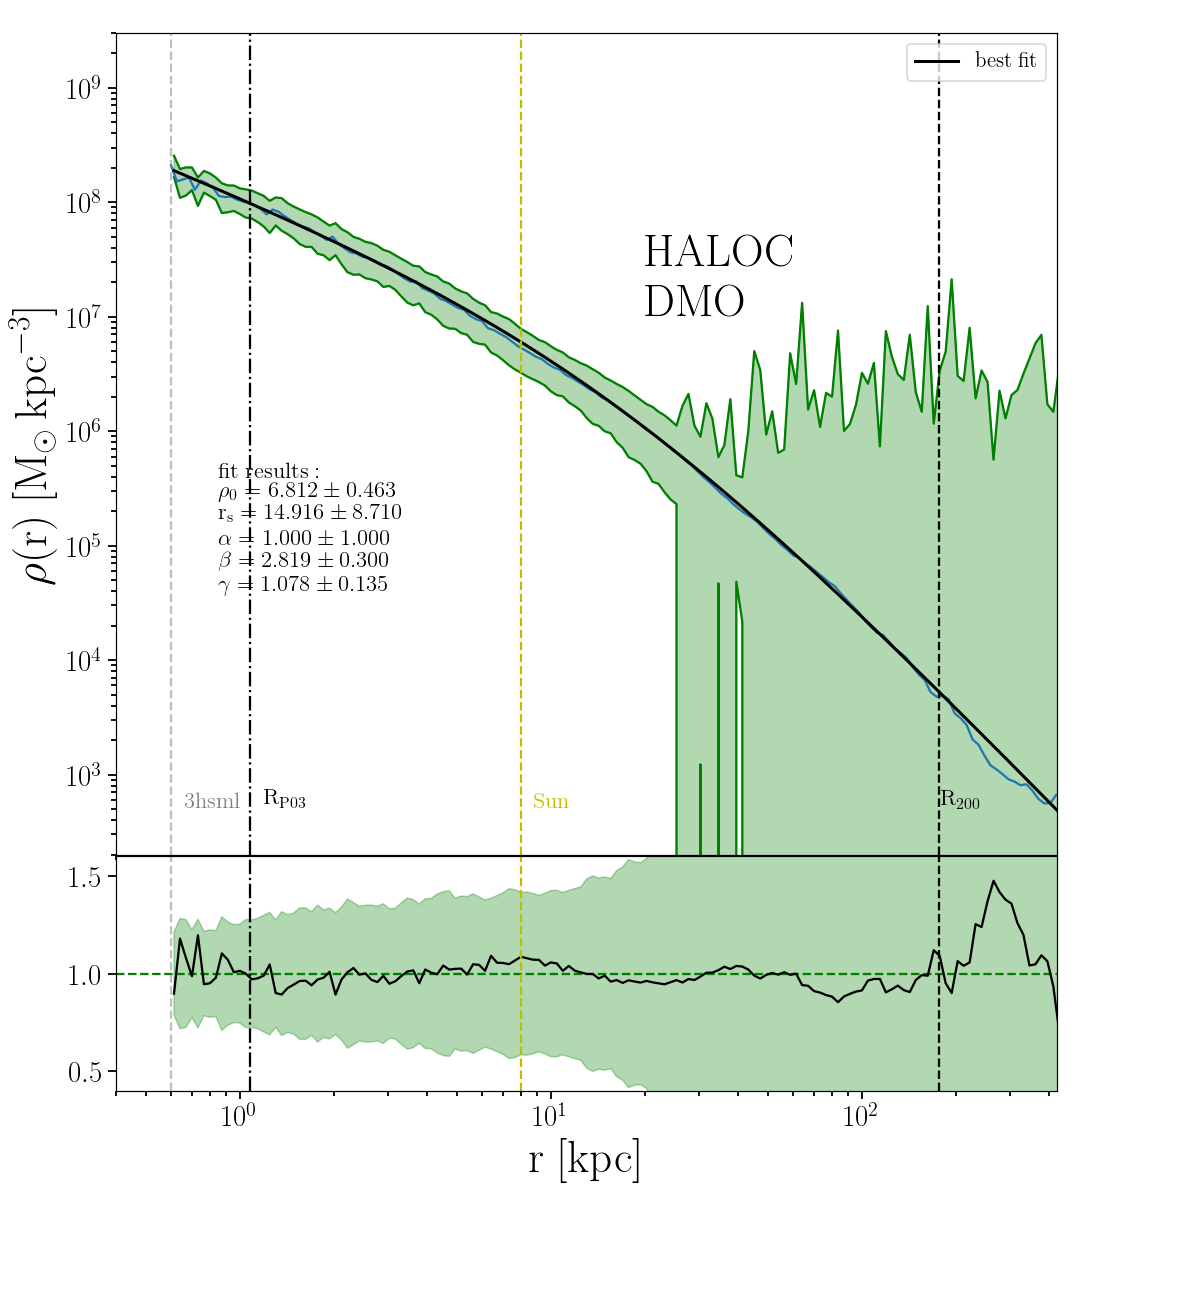

In [15]:
fig, [ax,ax1] = plt.subplots(2,1,gridspec_kw = {'height_ratios':[3.5, 1]},figsize=[10,11],sharex=True)
ax.set_xlim([2*hsml,2.4*myDMO.r200])
ax1.set_xlim([2*hsml,2.4*myDMO.r200])
ax1.set_ylim([.4,1.6])
ax.set_ylim([2e2,3e9])
ax.set_xscale('log')
ax1.set_xscale('log')
ax.set_yscale('log')
ax1.set_xlabel(r'$\rm r \;[kpc]$',fontsize=labelsize)
ax.set_ylabel(r'$\rm \rho(r)\;[M_{\odot}\, kpc^{-3}]$',fontsize=labelsize)


#define sigma pluss and sigma minus lines
mean_plus = profileDMO+std
mean_minu = profileDMO-std

#  plot things
mean_minu[np.isnan(np.log10(mean_minu))] = 0
ax.plot(r[~np.isnan(np.log10(mean_plus))],mean_plus[~np.isnan(np.log10(mean_plus))],
        c='g')
ax.plot(r[~np.isnan(np.log10(mean_minu))],mean_minu[~np.isnan(np.log10(mean_minu))],
        c='g')

ax.fill_between(r,mean_plus,mean_minu,color="g",alpha=0.3)

ax.plot(r_p[:-1],profileDMO,lw=1.5)
## rho fit
ax.plot(r,(abg_profile(r,m_rho.values['po'] ,m_rho.values['r_s'],m_rho.values['al'],m_rho.values['be'],m_rho.values['ga'])),
        "k",lw=2,label=r"$\rm best\;fit$")
exis = 0.2
texto = r"$\rm fit \; results: $"#+"\n"
fig.text(exis,0.6,texto,fontsize=textsize)
texto = r"$\rm \rho_0 = {0:.3f} \pm {1:.3f}$".format(m_rho.values["po"],m_rho.errors["po"])
fig.text(exis,0.582,texto,fontsize=textsize)
texto = r"$\rm r_s = {0:.3f} \pm {1:.3f}$".format(m_rho.values["r_s"],m_rho.errors["r_s"])
fig.text(exis,0.564,texto,fontsize=textsize)
texto = r"$\rm \alpha = {0:.3f} \pm {1:.3f}$".format(m_rho.values["al"],m_rho.errors["al"])
fig.text(exis,0.546,texto,fontsize=textsize)
texto = r"$\rm \beta = {0:.3f} \pm {1:.3f}$".format(m_rho.values["be"],m_rho.errors["be"])
fig.text(exis,0.526,texto,fontsize=textsize)
texto = r"$\rm \gamma = {0:.3f} \pm {1:.3f}$".format(m_rho.values["ga"],m_rho.errors["ga"])
fig.text(exis,0.506,texto,fontsize=textsize)

ax.text(20,1e7,r"$\rm "+simname+"$"+"\n"+r"$\rm DMO$",fontsize=labelsize)



ax.text(3*hsml*1.1,5e2,r"$\rm 3hsml$",color='gray',fontsize=textsize)
ax.text(1.1*R_P03,5e2,r"$\rm R_{P03}$",color='k',fontsize=textsize)
ax.text(8*1.1,5e2,r"$\rm Sun$",color='y',fontsize=textsize)
ax.text(myDMO.r200*1.01,5e2,r"$\rm R_{200}$",color='k',fontsize=textsize)
r_dm = r


#horizontal lines
ax.axvline(x=hsml,c='gray',alpha=0.5,linestyle='--',lw=1.5)
ax.axvline(x=3*hsml,c='gray',alpha=0.5,linestyle='--',lw=1.5)
ax.axvline(x=8,c='y',linestyle='--',lw=1.5) #Sun
ax.axvline(x=myDMO.r200,c='k',linestyle='--',lw=1.5) #r200
ax.axvline(x=R_P03,c='k',linestyle='-.',lw=1.5) #power radius
#########33

##
ax1.axhline(y=1.,color="g",linestyle="--")
## rho fit
r_local = np.logspace(np.log10(hsml),np.log10(2.5*myDMO.r200),100)
ax1.plot(r,(abg_profile(r,m_rho.values['po'] ,m_rho.values['r_s'],m_rho.values['al'],m_rho.values['be'],m_rho.values['ga']))/profileDMO,
        "k",lw=1.5,label=r"$\chi^2(\rho)$")

ax1.plot(r_in,(abg_profile(r_in,m_rho.values['po'] ,m_rho.values['r_s'],m_rho.values['al'],m_rho.values['be'],m_rho.values['ga']))/profileDMO_in,
        "k--",lw=1.5,label=r"$\chi^2(\rho)$")

ax1.fill_between(r,mean_plus/profileDMO,mean_minu/profileDMO,color="g",alpha=0.3)

#horizontal lines
ax1.axvline(x=hsml,c='gray',alpha=0.5,linestyle='--',lw=1.5)
ax1.axvline(x=3*hsml,c='gray',alpha=0.5,linestyle='--',lw=1.5)
ax1.axvline(x=8,c='y',linestyle='--',lw=1.5) #Sun
ax1.axvline(x=myDMO.r200,c='k',linestyle='--',lw=1.5) #r200
ax1.axvline(x=R_P03,c='k',linestyle='-.',lw=1.5) 

legend = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=14)
frame = legend.get_frame()
# layout
plt.tight_layout(pad=2 ,h_pad=-0.39)
ax.tick_params(axis='both', which='major', labelsize=tickssize, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=tickssize, size=3,width=1.2)
ax1.tick_params(axis='both', which='major', labelsize=tickssize, size=5,width=1.2)
ax1.tick_params(axis='both', which='minor', labelsize=tickssize, size=3,width=1.2)

In [16]:
path2file = "/home/arturo/Documents/LAM/LAM2LUPM/dataFiles/profiles/"
outfile = open(path2file+dmo.namenospace+"_DMO_profile_cphi.dat","w")
outfile.write("# SIM: "+ dmo.namenospace+" DMO\n")
outfile.write("# center: minima of Potential ")
outfile.write("# date: {0} \n".format(datetime.datetime.now()))
outfile.write("# r200: "+str(myDMO.r200)+" kpc \n")
outfile.write("# FORMAT:\n")
outfile.write("#   r  ,     rho     ,    sigma,     sigma_log \n")
outfile.write("# [kpc], [Msun/kpc^3], [Msun/kpc^3], log([Msun/kpc^3])  \n")
for i in range(len(r)):
    outfile.write("{0:.3f} , {1:.4e} , {2:.4e}, {3:.5f} \n".format(r[i],profileDMO[i],std[i],stdlog[i]))

outfile.close()

In [ ]:
#### TAKES TIME ####

myGkpc = 6.673e-11*((1e-3/myDMO.p.kpctokm)**3)*myDMO.p.msuntokg#kpc^ 3 Msun^-1 s^-2
pos = np.array(myDMO.dm.pos3d.reshape(len(myDMO.dm.pos3d)*3),dtype=np.float32)#*myDMO.p.kpctokm
#ok, acc, Phy = CF.getGravity(pos,myDMO.dm.mass,0.190,G=myGkpc)

In [ ]:
"""
bin_num = 512

pot_sph, bins_pot = np.histogram(r2,bins=bin_num,
                                 weights=Phy)
n, _ = np.histogram(r2,bins=bin_num)

bin_num = 512
bins_pot = np.linspace(0.,myDMO.dm.r.max(),512)
pot_sph_vesc, bins_pot_vesc = np.histogram(r2[(r2<myDMO.r200**2)], bins=bin_num, weights=Phy[(r2<myDMO.r200**2)])
rmax = np.sqrt(bins_pot[(pot_sph/n)==(pot_sph/n)[(bins_pot<503.**2)].max()])[0]
pot_max = (pot_sph/n)[(pot_sph/n)==(pot_sph/n)[(bins_pot<503.**2)].max()][0]
"""

# Hydro

'/data/POL/HALOC_19/Hydro/output_00440'

In [31]:

pathsim = "/data/POL/HALOC_19/Hydro/output_00440"
#path = "/media/arturo/ARTUROTECA/OUTPUTS/HaloB/output_00417"
myhydro = wkbl.Galaxy_Hound(hydro.path)
ok,rho,_= CF.getDensity(np.array(myhydro.st.pos3d.reshape(len(myhydro.st.pos3d)*3),dtype=np.float32), myhydro.st.mass)
centro_rho = myhydro.st.pos3d[np.where(rho == rho.max())][0]
print "density",centro_rho
myhydro.center_shift(centro_rho)
myhydro.r_virial(600,n=2.5)

In [15]:
ok,myhydro.dm.rho,_= CF.getDensity(np.array(myhydro.dm.pos3d.reshape(len(myhydro.dm.pos3d)*3),dtype=np.float32), myhydro.dm.mass)

In [18]:
pos_dm = np.array(myhydro.dm.pos3d.reshape(len(myhydro.dm.pos3d)*3),dtype=np.float32)
pos_gs = np.array(myhydro.gs.pos3d.reshape(len(myhydro.gs.pos3d)*3),dtype=np.float32)
pos_st = np.array(myhydro.st.pos3d.reshape(len(myhydro.st.pos3d)*3),dtype=np.float32)
pos = np.concatenate((pos_dm, pos_st, pos_gs))
phi_cord = np.concatenate((myhydro.dm.phi,myhydro.st.phi, myhydro.gs.phi))

mass = np.concatenate((myhydro.dm.mass,myhydro.st.mass,myhydro.gs.mass))
v = np.concatenate((myhydro.dm.v,myhydro.st.v,myhydro.gs.v))
print len(mass)*3, len(pos)
pos3d = pos.reshape(len(pos)/3,3)
r2 = pos3d[:,0]**2 + pos3d[:,1]**2 +pos3d[:,2]**2

ok,myhydro.dm.rho,_= CF.getDensity(np.array(myhydro.dm.pos3d.reshape(len(myhydro.dm.pos3d)*3),dtype=np.float32), myhydro.dm.mass)
ok, acc, Phy = CF.getGravity(pos,mass,0.15,G=myhydro.p.G)
Phy = Phy * myhydro.p.kpctokm**2

51353718 51353718


In [19]:
if (center_in_pot):
    pot_cen = pos3d[Phy==Phy.min()][0]
    print pot_cen
    inside = myhydro.dm.r<10
    dens_cen = (myhydro.dm.pos3d[inside])[myhydro.dm.rho[inside]==myhydro.dm.rho[inside].max()][0]
    print dens_cen

    myhydro.center_shift(pot_cen)
    myhydro.r_virial(600,n=2.5)

    pos_dm = np.array(myhydro.dm.pos3d.reshape(len(myhydro.dm.pos3d)*3),dtype=np.float32)
    pos_gs = np.array(myhydro.gs.pos3d.reshape(len(myhydro.gs.pos3d)*3),dtype=np.float32)
    pos_st = np.array(myhydro.st.pos3d.reshape(len(myhydro.st.pos3d)*3),dtype=np.float32)
    pos = np.concatenate((pos_dm, pos_st, pos_gs))
    phi_cord = np.concatenate((myhydro.dm.phi,myhydro.st.phi, myhydro.gs.phi))

    mass = np.concatenate((myhydro.dm.mass,myhydro.st.mass,myhydro.gs.mass))
    v = np.concatenate((myhydro.dm.v,myhydro.st.v,myhydro.gs.v))
    print len(mass)*3, len(pos)
    pos3d = pos.reshape(len(pos)/3,3)
    r2 = pos3d[:,0]**2 + pos3d[:,1]**2 +pos3d[:,2]**2

    ok,myhydro.dm.rho,_= CF.getDensity(np.array(myhydro.dm.pos3d.reshape(len(myhydro.dm.pos3d)*3),dtype=np.float32), myhydro.dm.mass)
    ok, acc, Phy = CF.getGravity(pos,mass,0.15,G=myhydro.p.G)
    Phy = Phy * myhydro.p.kpctokm**2

[-0.28506315 -0.2353559   0.04095203]
[-0.52407712  0.09260532 -0.55042887]


## virial parameter q

In [22]:
"""
pos_bar = np.concatenate((myhydro.st.pos3d, myhydro.gs.pos3d))
mass_bar = np.concatenate((myhydro.st.mass,myhydro.gs.mass))
nbe.real_center(pos_bar,mass_bar)
pos = np.concatenate((myhydro.dm.pos3d, myhydro.st.pos3d, myhydro.gs.pos3d))*1e-2*myhydro.p.pctocm # km
mass = np.concatenate((myhydro.dm.mass,myhydro.st.mass,myhydro.gs.mass))
r_par = np.sqrt((pos[:,0]**2)+(pos[:,1]**2)+(pos[:,2]**2))
r_sorted = np.argsort(r_par)
M_i = np.cumsum(mass[r_sorted])
m_i = mass[r_sorted]
r_i = r_par[r_sorted]
U_hydro = np.sum(-myG*M_i*m_i/r_i)
k_B = 1.3806503e-23 *1e-6/ myhydro.p.msuntokg
m_H = myhydro.p.mH*1e-3/ myhydro.p.msuntokg
E_k_dm = 0.5*(myhydro.dm.v**2)*myhydro.dm.mass
E_k_st = 0.5*(myhydro.st.v**2)*myhydro.st.mass
E_k_gs = 1.5* myhydro.gs.mass * myhydro.gs.temp2 * (k_B / m_H)#0.5*(myhydro.gs.v**2)*myhydro.gs.mass
K_hydro = np.sum(2*E_k_dm)+np.sum(2*E_k_st)+np.sum(2*E_k_gs)
K_hydro / U_hydro +1
print "E_DM = {0:1.4e}, E_st = {1:1.4e}, E_gs = {2:1.4e}".format(np.sum(2*E_k_dm),np.sum(2*E_k_st),np.sum(2*E_k_gs))
"""

'\npos_bar = np.concatenate((myhydro.st.pos3d, myhydro.gs.pos3d))\nmass_bar = np.concatenate((myhydro.st.mass,myhydro.gs.mass))\nnbe.real_center(pos_bar,mass_bar)\npos = np.concatenate((myhydro.dm.pos3d, myhydro.st.pos3d, myhydro.gs.pos3d))*1e-2*myhydro.p.pctocm # km\nmass = np.concatenate((myhydro.dm.mass,myhydro.st.mass,myhydro.gs.mass))\nr_par = np.sqrt((pos[:,0]**2)+(pos[:,1]**2)+(pos[:,2]**2))\nr_sorted = np.argsort(r_par)\nM_i = np.cumsum(mass[r_sorted])\nm_i = mass[r_sorted]\nr_i = r_par[r_sorted]\nU_hydro = np.sum(-myG*M_i*m_i/r_i)\nk_B = 1.3806503e-23 *1e-6/ myhydro.p.msuntokg\nm_H = myhydro.p.mH*1e-3/ myhydro.p.msuntokg\nE_k_dm = 0.5*(myhydro.dm.v**2)*myhydro.dm.mass\nE_k_st = 0.5*(myhydro.st.v**2)*myhydro.st.mass\nE_k_gs = 1.5* myhydro.gs.mass * myhydro.gs.temp2 * (k_B / m_H)#0.5*(myhydro.gs.v**2)*myhydro.gs.mass\nK_hydro = np.sum(2*E_k_dm)+np.sum(2*E_k_st)+np.sum(2*E_k_gs)\nK_hydro / U_hydro +1\nprint "E_DM = {0:1.4e}, E_st = {1:1.4e}, E_gs = {2:1.4e}".format(np.sum(2*E_k_d

## mass fit

In [78]:
Pcrit = myhydro.dm._p.rho_crit
Mdm = myhydro.dm.mass.min()
myradiuses = myhydro.dm.r[np.argsort(myhydro.dm.r)]
tabN = np.cumsum(np.ones(len(myradiuses)))[1:]
myradiuses = myradiuses[1:]
Rp03 = np.sqrt(200/64.) * np.sqrt(4 * np.pi * Pcrit * tabN / 3. / Mdm ) * (myradiuses**1.5)/ np.log(tabN) 
val =0.6
R_P03 = myradiuses[ np.where(Rp03 > val) ][0]
print R_P03
hsml=  myhydro.gs.hsml.min()

# R array logarithmic Bining
r_p = np.logspace(np.log10(0.2*hsml),np.log10(hsml),15)
# histogram of dm particles per logarithmic bin
n_hydro,r = np.histogram(myhydro.dm.r,bins=r_p)
# edges of bins
r1,r2 =r[:-1],r[1:]
# shell's volume
vol = 4.* np.pi * ((r2**3)-(r1**3)) / 3.
# density per shell
profilehydro_in = n_hydro*myhydro.dm.mass.min()/vol
# center of bins
r_in = (r_p[:-1]+r_p[1:])/2.



# R array logarithmic Bining
r_p = np.logspace(np.log10(2*hsml),np.log10(2.5*myhydro.r200),100)
# histogram of dm particles per logarithmic bin
n_hydro,r = np.histogram(myhydro.dm.r,bins=r_p)
# edges of bins
r1,r2 =r[:-1],r[1:]
# shell's volume
vol = 4.* np.pi * ((r2**3)-(r1**3)) / 3.
# density per shell
profilehydro = n_hydro*myhydro.dm.mass.min()/vol
# center of bins
r = (r_p[:-1]+r_p[1:])/2.
bin_size= (r_p[:-1]-r_p[1:])/2.
rr = r
# extra estatistics from Cfalcon density
mean_hydro = std_hydro = stdlog_hydro = n_hydro=np.array([])
for i in range(len(r_p)-1):
    shell_hydro = np.where((myhydro.dm.r > r_p[i])&(myhydro.dm.r < r_p[i+1])&(myhydro.dm.r > hsml))
    n_hydro = np.append(n_hydro,len(shell_hydro[0]))
    mean_hydro = np.append(mean_hydro,np.mean(myhydro.dm.rho[shell_hydro]))
    std_hydro = np.append(std_hydro,np.std(myhydro.dm.rho[shell_hydro]))
    stdlog_hydro = np.append(stdlog_hydro,np.std(np.log10(myhydro.dm.rho[shell_hydro])))

m_obs_hydro = n_hydro*myhydro.dm.mass.min()
n_hydro = np.array([len(myhydro.dm.mass[myhydro.dm.r<i]) for i in r]) 


1.1195559734377416


In [79]:


def chi2_mass_bin_hydro(po,r_s,al,be,ga):
    """
    logarithmic Chi-square
    using the full mass inside a shell
    between Ri and Rf
    """
    def my_int(Ri,Rf):
        r_test = np.logspace(np.log10(Ri),np.log10(Rf),100)
        rho_test =  (r_test**2) * abg_profile(r_test,po,r_s,al,be,ga)
        return 4* np.pi * simps(rho_test,r_test)
    expected = np.array([my_int(r_p[i],r_p[i+1]) for i in range(len(r))])
    c = (np.log10(m_obs_hydro)- np.log10(expected))
    c = c**2
    return np.sum(c)


def chi2_rho_hydro(po,r_s,al,be,ga):
    rho_obs = profilehydro
    rho_the = np.array([abg_profile(i,po,r_s,al,be,ga) for i in r])
    c = (np.log10(rho_the) - np.log10(rho_obs))/ stdlog_hydro
    c = c**2
    return np.sum(c)

In [80]:
m_rho_hydro = Minuit(chi2_rho_hydro,
         po=5.0,    error_po=0.01,  limit_po =(2.,9.),
         r_s=4.3,  error_r_s=0.1,   limit_r_s=(1.,30),
         al=2.8,     error_al=0.1,   limit_al=(0.5,4),
         be=2.5,     error_be=0.1,   limit_be =(2.,3.5),
         ga=0,     error_ga=0.1,   limit_ga =(0.0,1.5))
m_rho_hydro.migrad();
chirhorho = chi2_rho_hydro(m_rho_hydro.values['po'] ,m_rho_hydro.values['r_s'],m_rho_hydro.values['al'],m_rho_hydro.values['be'],m_rho_hydro.values['ga'])
chibinrho= chi2_mass_bin_hydro(m_rho_hydro.values['po'] ,m_rho_hydro.values['r_s'],m_rho_hydro.values['al'],m_rho_hydro.values['be'],m_rho_hydro.values['ga'])
print "chi_rho = {0:1.2f}, chi_bin = {1:1.2f}".format(chirhorho,chibinrho)

FCN = 28.0464388607 
 TOTAL NCALL = 646 
 NCALLS = 646 
 
 
 EDM = 5.7482402107e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 po 
 7.58594 
 0.0755627 
 
 
 2 
 9 
 No 
 
 
 1 
 r_s 
 4.66189 
 0.426886 
 
 
 1 
 30 
 No 
 
 
 2 
 al 
 2.98196 
 0.881411 
 
 
 0.5 
 4 
 No 
 
 
 3 
 be 
 2.45955 
 0.0851404 
 
 
 2 
 3.5 
 No 
 
 
 4 
 ga 
 0.379644 
 0.0732179 
 
 
 0 
 1.5 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & po & 7.58594 & 0.0755627 & & & 2.0 & 9 & No\\
\hline
1 & $r_{s}$ & 4.66189 & 0.426886 & & & 1.0 & 30 & No\\
\hline
2 & al & 2.98196 & 0.881411 & & & 0.5 & 4 & No\\
\hline
3 & be & 2.45955 & 0.0851404 & & & 2.0 & 3.5 & No\\
\hline
4 & ga & 0.379644 & 0.0732179 & & & 0.0 & 1.5 & No\\
\hline
\end{tabular}

chi_rho = 28.05, chi_bin = 0.65


In [81]:
m_binH = Minuit(chi2_mass_bin_hydro,
         po=7.0,    error_po=0.01,  limit_po =(6.,9.),
         r_s=4.3,  error_r_s=0.1,   limit_r_s=(1.,20),
         al=2.8,     error_al=0.1,   limit_al=(0.5,4),
         be=2.5,     error_be=0.1,   limit_be =(2.,3.5),
         ga=0,     error_ga=0.1,   limit_ga =(0.0,1.5))
m_binH.migrad();
chirhobin = chi2_rho_hydro(m_binH.values['po'] ,m_binH.values['r_s'],m_binH.values['al'],m_binH.values['be'],m_binH.values['ga'])
chibinbin= chi2_mass_bin_hydro(m_binH.values['po'] ,m_binH.values['r_s'],m_binH.values['al'],m_binH.values['be'],m_binH.values['ga'])
print "chi_rho = {0:1.2f}, chi_bin = {1:1.2f}".format(chirhobin,chibinbin)


FCN = 0.639417882346 
 TOTAL NCALL = 280 
 NCALLS = 280 
 
 
 EDM = 3.59074400471e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 po 
 7.64149 
 0.860074 
 
 
 6 
 9 
 No 
 
 
 1 
 r_s 
 4.4292 
 3.555 
 
 
 1 
 20 
 No 
 
 
 2 
 al 
 2.71869 
 1.90708 
 
 
 0.5 
 4 
 No 
 
 
 3 
 be 
 2.45945 
 0.31834 
 
 
 2 
 3.5 
 No 
 
 
 4 
 ga 
 0.31513 
 0.834839 
 
 
 0 
 1.5 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & po & 7.64149 & 0.860074 & & & 6.0 & 9 & No\\
\hline
1 & $r_{s}$ & 4.4292 & 3.555 & & & 1.0 & 20 & No\\
\hline
2 & al & 2.71869 & 1.90708 & & & 0.5 & 4 & No\\
\hline
3 & be & 2.45945 & 0.31834 & & & 2.0 & 3.5 & No\\
\hline
4 & ga & 0.31513 & 0.834839 & & & 0.0 & 1.5 & No\\
\hline
\end{tabular}

chi_rho = 29.05, chi_bin = 0.64


In [82]:
#polfit
chirhopol = chi2_rho_hydro(7.663,4.425,2.895,2.541,8e-9)
chibinpol= chi2_mass_bin_hydro(7.663,4.425,2.895,2.541,8e-9)
print "chi_rho = {0:1.2f}, chi_bin = {1:1.2f}".format(chirhopol,chibinpol)

chi_rho = 282.97, chi_bin = 2.37


<IPython.core.display.Javascript object>


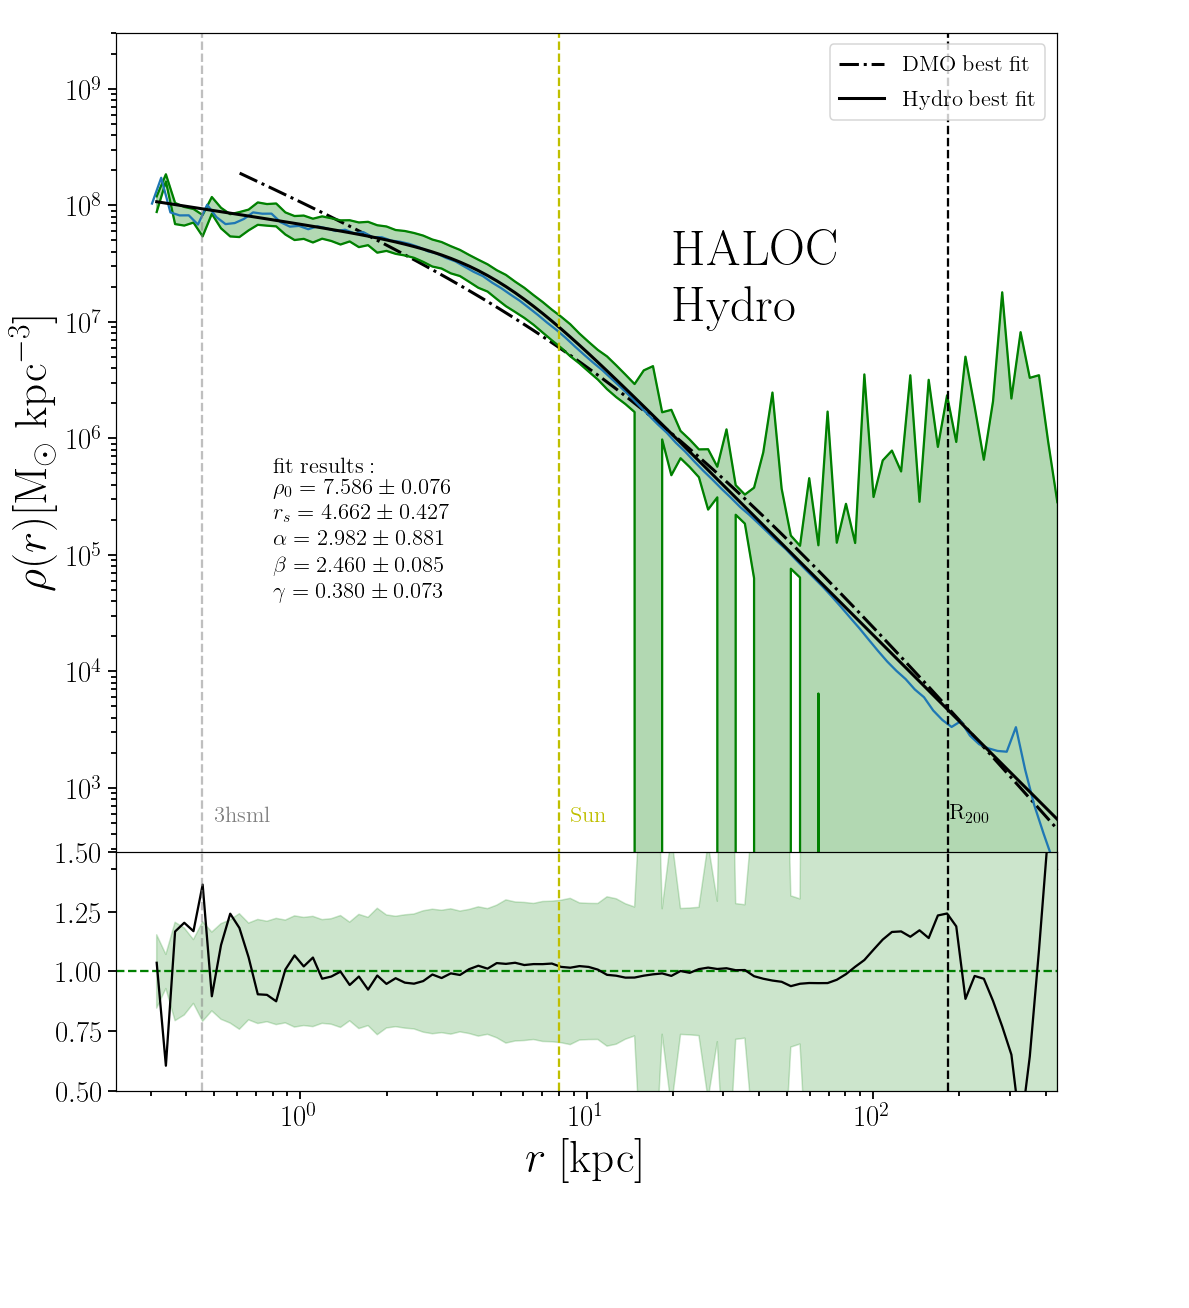

In [83]:
fig, [ax,ax1] = plt.subplots(2,1,gridspec_kw = {'height_ratios':[3.5, 1]},sharex=True,figsize=[10,11])
ax.set_xlim([1.5*hsml,2.4*myhydro.r200])
ax1.set_xlim([1.5*hsml,2.4*myhydro.r200])
ax1.set_ylim([.5,1.5])
ax.set_ylim([2e2,3e9])
ax.set_xscale('log')
ax1.set_xscale('log')
ax.set_yscale('log')
ax1.set_xlabel(r'$r \rm\;[kpc]$',fontsize=labelsize)
ax.set_ylabel(r'$\rho(r)\rm [M_{\odot}\; kpc^{-3}]$',fontsize=labelsize)


#define sigma pluss and sigma minus lines
mean_plus = profilehydro+std_hydro
mean_minu = profilehydro-std_hydro
ax.plot(r_dmo_profile,(abg_profile(r_dmo_profile,m_rho.values['po'] ,m_rho.values['r_s'],
                                   m_rho.values['al'],m_rho.values['be'],m_rho.values['ga'])),
        "k-.",lw=2,alpha=1,label=r'$\rm DMO\; best\;fit$')
#  plot things
#ax.scatter(myhydro.dm.r,myhydro.dm.rho,s=0.02,lw=0,alpha=0.6,c='#FF9100')
mean_minu[np.isnan(np.log10(mean_minu))] = 0
ax.plot(r[~np.isnan(np.log10(mean_plus))],mean_plus[~np.isnan(np.log10(mean_plus))],
        c='g')
ax.plot(r[~np.isnan(np.log10(mean_minu))],mean_minu[~np.isnan(np.log10(mean_minu))],
        c='g')

ax.fill_between(r,mean_plus,mean_minu,color="g",alpha=0.3)
#ax.errorbar(r,profileDMO,xerr=bin_size,yerr=std,alpha=0.5)

#ax.scatter(myhydro.dm.r,myhydro.dm.rho,s=0.2,lw=0,alpha=0.2,c='gray')

#plot means
#ax.plot(r_p[:-1],mean,lw=1.5)
ax.plot(r_p[:-1],profilehydro,lw=1.5)
## rho fit
ax.plot(r,(abg_profile(r,m_rho_hydro.values['po'] ,m_rho_hydro.values['r_s'],
                       m_rho_hydro.values['al'],m_rho_hydro.values['be'],
                       m_rho_hydro.values['ga'])),
        "k",lw=2,label=r"$\rm Hydro\; best\;fit$")

texto = r"$\rm fit \; results: $"#+"\n"
fig.text(0.25,0.604,texto,fontsize=textsize)
texto = r"$\rho_0 = {0:.3f} \pm {1:.3f}$".format(m_rho_hydro.values["po"],m_rho_hydro.errors["po"])
fig.text(0.25,0.584,texto,fontsize=textsize)
texto = r"$r_s = {0:.3f} \pm {1:.3f}$".format(m_rho_hydro.values["r_s"],m_rho_hydro.errors["r_s"])
fig.text(0.25,0.564,texto,fontsize=textsize)
texto = r"$\alpha = {0:.3f} \pm {1:.3f}$".format(m_rho_hydro.values["al"],m_rho_hydro.errors["al"])
fig.text(0.25,0.546,texto,fontsize=textsize)
texto = r"$\beta = {0:.3f} \pm {1:.3f}$".format(m_rho_hydro.values["be"],m_rho_hydro.errors["be"])
fig.text(0.25,0.522,texto,fontsize=textsize)
texto = r"$\gamma = {0:.3f} \pm {1:.3f}$".format(m_rho_hydro.values["ga"],m_rho_hydro.errors["ga"])+"\n"
fig.text(0.25,0.478,texto,fontsize=textsize)



ax.text(20,1e7,r"$\rm "+hydro.namenospace+"$"+"\n"+r"$\rm Hydro$",fontsize=1.1*labelsize)
ax.text(3*hsml*1.1,5e2,r"$\rm 3hsml$",color='gray',fontsize=textsize)
ax.text(8*1.1,5e2,r"$\rm Sun$",color='y',fontsize=textsize)
ax.text(myhydro.r200*1.01,5e2,r"$\rm R_{200}$",color='k',fontsize=textsize)
r_dm = r

#horizontal lines
ax.axvline(x=hsml,c='gray',alpha=0.5,linestyle='--',lw=1.5)
ax.axvline(x=3*hsml,c='gray',alpha=0.5,linestyle='--',lw=1.5)
ax.axvline(x=8,c='y',linestyle='--',lw=1.5) #Sun
ax.axvline(x=myhydro.r200,c='k',linestyle='--',lw=1.5) #r200

legend = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=textsize)
frame = legend.get_frame()
#########33

##
ax1.axhline(y=1.,color="g",linestyle="--")
## rho fit
r_local = np.logspace(np.log10(hsml),np.log10(2.5*myhydro.r200),100)
ax1.plot(r,(abg_profile(r,m_rho_hydro.values['po'],m_rho_hydro.values['r_s'],
                          m_rho_hydro.values['al'],m_rho_hydro.values['be'],
                          m_rho_hydro.values['ga']))/profilehydro,
        "k",lw=1.5,label=r"$\chi^2(\rho)$ ")



ax1.fill_between(r,mean_plus/profilehydro,mean_minu/profilehydro,color="g",alpha=0.2)



#horizontal lines
ax1.axvline(x=hsml,c='gray',alpha=0.5,linestyle='--',lw=1.5)
ax1.axvline(x=3*hsml,c='gray',alpha=0.5,linestyle='--',lw=1.5)
ax1.axvline(x=8,c='y',linestyle='--',lw=1.5) #Sun
ax1.axvline(x=myhydro.r200,c='k',linestyle='--',lw=1.5) #r200


# layout
plt.tight_layout(pad=2 ,h_pad=-1.65)
ax.tick_params(axis='both', which='major', labelsize=tickssize, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=tickssize, size=3,width=1.2)
ax1.tick_params(axis='both', which='major', labelsize=tickssize, size=5,width=1.2)
ax1.tick_params(axis='both', which='minor', labelsize=tickssize, size=3,width=1.2)

#plt.savefig("/home/arturo/Documents/LAM/LAM2LUPM/Mochima/coco.png")
##########################################################################################
##########################################################################################


In [86]:
path2file = "/home/arturo/Documents/LAM/LAM2LUPM/dataFiles/profiles/"
outfile = open(path2file+hydro.namenospace+"_hydro_profile_cphi.dat","w")
outfile.write("# SIM: "+ hydro.namenospace+" hydro\n")
outfile.write("# center: minima of Potential ")
outfile.write("# date: {0} \n".format(datetime.datetime.now()))
outfile.write("# r200: "+str(myhydro.r200)+" kpc \n")
outfile.write("# fit results: \n")
outfile.write("# rho_0 = {0:.3f} \pm {1:.3f} \n".format(m_rho_hydro.values["po"],m_rho_hydro.errors["po"]))
outfile.write("# r_s = {0:.3f} \pm {1:.3f}\n".format(m_rho_hydro.values["r_s"],m_rho_hydro.errors["r_s"]))
outfile.write("# alpha = {0:.3f} \pm {1:.3f}\n".format(m_rho_hydro.values["al"],m_rho_hydro.errors["al"]))
outfile.write("# beta = {0:.3f} \pm {1:.3f}\n".format(m_rho_hydro.values["be"],m_rho_hydro.errors["be"]))
outfile.write("# gamma = {0:.3f} \pm {1:.3f}\n".format(m_rho_hydro.values["ga"],m_rho_hydro.errors["ga"]))
outfile.write("# FORMAT:\n")
outfile.write("#   r  ,     rho     ,    sigma,     sigma_log \n")
outfile.write("# [kpc], [Msun/kpc^3], [Msun/kpc^3], log([Msun/kpc^3])  \n")
for i in range(len(r)):
    outfile.write("{0:.3f} , {1:.4e} , {2:.4e}, {3:.5f} \n".format(r[i],profilehydro[i],std_hydro[i],stdlog_hydro[i]))

outfile.close()

In [85]:
print "###################################################"
print "##################### LUPM ########################"
print "################# Mochima Hydro ###################"
print "###################################################"
print "##################  DM profile ####################"

print texto

###################################################
##################### LUPM ########################
################# Mochima Hydro ###################
###################################################
##################  DM profile ####################
$\gamma = 0.380 \pm 0.073$



In [33]:
def my_int(Ri,Rf,po,r_s,al,be,ga):
    r_test = np.logspace(np.log10(Ri),np.log10(Rf),100)
    rho_test =  (r_test**2) * abg_profile(r_test,po,r_s,al,be,ga)
    return 4* np.pi * simps(rho_test,r_test)

print "integrated mass fit = {0:1.3e}".format(my_int(hsml,myhydro.r200,m_rho_hydro.values['po'] ,m_rho_hydro.values['r_s'],m_rho_hydro.values['al'],m_rho_hydro.values['be'],m_rho_hydro.values['ga']))
print "integrates rho fit = {0:1.3e}".format(my_int(hsml,myhydro.r200,m_binH.values['po'] ,m_binH.values['r_s'],m_binH.values['al'],m_binH.values['be'],m_binH.values['ga']))
print "mass inside r200 = {0:1.3e}".format(myhydro.dm.mass[(myhydro.dm.r>hsml)&(myhydro.dm.r<myhydro.r200)].sum())


integrated mass fit = 5.718e+11
integrates rho fit = 5.718e+11
mass inside r200 = 5.497e+11


# Stars 

In [87]:
ok,myhydro.st.rho,_= CF.getDensity(np.array(myhydro.st.pos3d.reshape(len(myhydro.st.pos3d)*3),dtype=np.float32), myhydro.st.mass)

In [88]:
stars_bins=70

print 10**1.3
xedges = np.logspace(-1,np.log10(12),stars_bins)
yedges = np.linspace(-1.,1.,stars_bins/2)
dens_hist = np.zeros([len(yedges)-1,len(xedges)-1])
sigma_st = sigma_log_st = np.zeros([len(yedges)-1,len(xedges)-1])

print dens_hist.shape
for i in range(len(xedges[:-1])):
    for j in range(len(yedges[:-1])):
        Rcon = (myhydro.st.R >= xedges[i] )&(myhydro.st.R < xedges[i+1] )
        Zcon = (myhydro.st.pos3d[:,2] >= yedges[j])&(myhydro.st.pos3d[:,2] < yedges[j+1])
        mass = np.sum(myhydro.st.mass[np.where(Rcon&Zcon)])
        sigma_st[j][i] = np.std(myhydro.st.rho[np.where(Rcon&Zcon)])
        sigma_log_st[j][i] = np.std(np.log10(myhydro.st.rho[np.where(Rcon&Zcon)]))
        volume = np.pi * (yedges[j+1]-yedges[j]) * (xedges[i+1]**2 - xedges[i]**2)
        dens_hist [j][i] = mass / volume 
    


19.9526231497
(34, 69)


In [89]:
def stars(R,z,B_0,r0,al,r_cut,q,d_0,z_d,Rd,D_0,z_D,RD):
    def McMBulge(U,B_0,r0,al,r_cut):
        x = np.sqrt(U[0]**2 + (U[1]/q)**2)
        bulge = (10**B_0) * np.exp(-(x/r_cut)**2) / (1 + (x/r0))**al
        return bulge

    def McMDisc(x,z,z_d,D_0,Rd):
        disc = (10**D_0) * np.exp(- (abs(z) / z_d) - (x / Rd))
        return disc
    U = [R,z]
    return (McMBulge(U,B_0,r0,al,r_cut)+McMDisc(U[0],U[1],z_d,d_0,Rd)+McMDisc(U[0],U[1],z_D,D_0,RD))



R_array = (xedges[1:] + xedges[:-1])/2
Z_array = (yedges[1:] + yedges[:-1])/2

R , Z = np.meshgrid(R_array,Z_array)

def chi2_st(B_0,r0,al,r_cut,q,d_0,z_d,Rd,D_0,z_D,RD):
    chi2_array =np.array([])
    expected = stars(R,Z,B_0,r0,al,r_cut,q,D_0,z_d,Rd,D_0,z_D,RD)
    observed = dens_hist
    c = ((observed) - (expected))
    c = c**2
    return np.nansum(c)


def mass_check(B_0,r0,al,r_cut,q,d_0,z_d,Rd,D_0,z_D,RD):
    bins = 101
    edge = 20
    zedge = edge/10.
    xe, ye = np.linspace(0,edge,bins ),np.linspace(-zedge,zedge,bins)
    R_test,Z_test = (xe[1:] + xe[:-1])/2 , (ye[1:] + ye[:-1])/2
    U = np.meshgrid(R_test,Z_test)
    rho = 2. * np.pi * R_test * stars(U[0],U[1],B_0,r0,al,r_cut,q,d_0,z_d,Rd,D_0,z_D,RD)
    I = np.zeros( len(rho) )
    for i in range(len(rho)):
        I[i] = np.trapz( rho[i], R_test )
    F = np.trapz( I, Z_test )
    data_in = np.sum(myhydro.st.mass[np.where((myhydro.st.R<50.)&(np.abs(myhydro.st.pos3d[:,2])<zedge))])
    diff = (data_in - F)**2
    return  diff

<IPython.core.display.Javascript object>


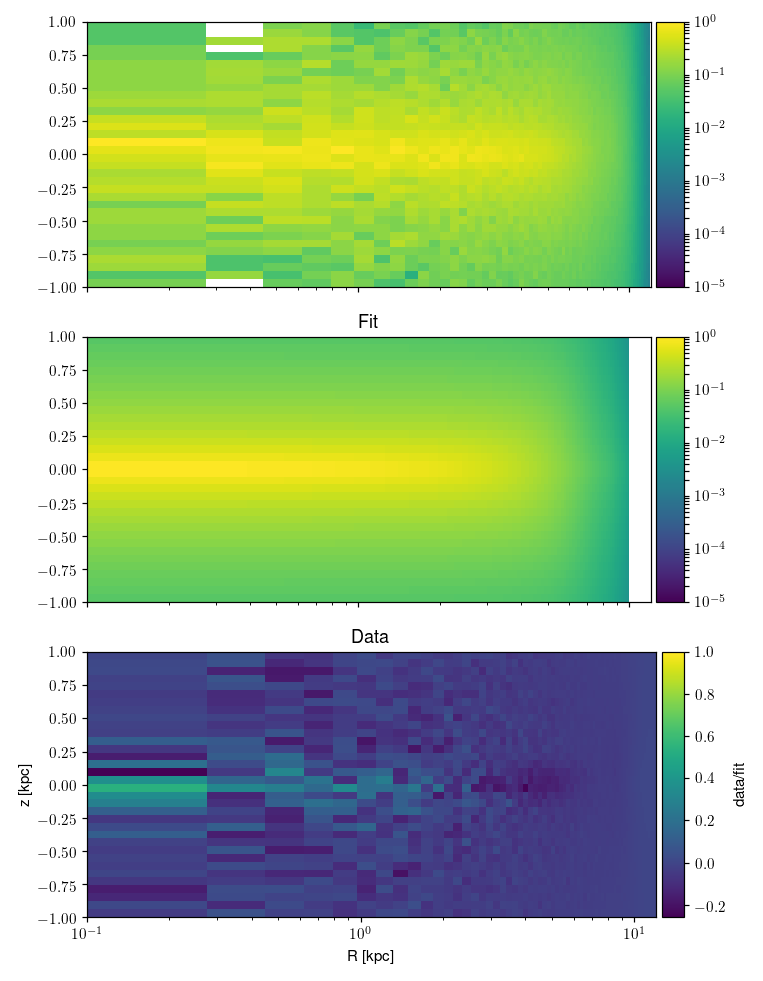

In [90]:
bins = stars_bins -1

x = np.logspace(-1,np.log10(10),bins)
y = np.linspace(-1,1,bins/2)

U= np.meshgrid(x, y)



Z = stars(U[0],U[1],9.5, .25 , 1.6 ,2.1,.5,
                    8, 0.5, 2.8,
                    8, 1.3 ,5.1)




fig ,[ax,ax1,ax2] = plt.subplots(3,1,figsize=[7,9],sharex=True, sharey=True)


plt.tight_layout(h_pad=2)
ax.set_xscale('log')
real = ax.imshow(dens_hist / dens_hist.max(), interpolation='nearest', origin='low',aspect='auto',
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],norm=LogNorm(vmin=1e-5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax)#,orientation='horizontal')

ax1.set_title("Fit")
ax1.set_xscale('log')

fit = ax1.imshow(Z/Z.max(), interpolation='nearest', origin='low',aspect='auto',
                  extent=[x[0], x[-1], y[0], y[-1]],norm=LogNorm(vmin=1e-5))
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax)


#print "fit  : max = {0:.3e}, min = {1:.3e}".format(Z.max(),Z.min())##print "data : max = {0:.3e}, min = {1:.3e}".format(dens_hist.max(),dens_hist.min())
ratio =  ((Z/Z.max())-(dens_hist/dens_hist.max()))#/(dens_hist/dens_hist.max())
#ratio =  np.abs(Z-dens_hist)/(dens_hist)

ax2.set_title("Data")
ax2.set_xlabel("R [kpc]")
ax2.set_ylabel("z [kpc]")
ax2.set_xscale('log')

real = ax2.imshow(ratio, interpolation='nearest', origin='low', vmax=1,aspect='auto',
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])#,norm=LogNorm(vmax=1e0))
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="4%", pad=0.05)
cbar = plt.colorbar(real,cax=cax,label='data/fit')
fig.tight_layout()

In [91]:
"""
Z = stars(U[0],U[1],9.5, .25 , 1.6 ,2.1,.5,
                    8, 0.6, 3.1,
                    8, 1.3 ,6.1)

"""

'\nZ = stars(U[0],U[1],9.5, .25 , 1.6 ,2.1,.5,\n                    8, 0.6, 3.1,\n                    8, 1.3 ,6.1)\n\n'

In [92]:
m1=Minuit(chi2_st, 
         B_0=9.6,    fix_B_0=True,#error_B_0=0.5,     limit_B_0=(9,10),
         r0=0.2,    error_r0=0.1,     limit_r0=(0.01,2),
         al=1.1,     error_al=0.1,    limit_al=(0,5.),
         r_cut=1.7,  error_r_cut=0.1,   limit_r_cut=(1,9.),
         q=0.5,      error_q=0.1,     limit_q=(0,1.),
         d_0=8.7,    fix_d_0=True,#error_d_0=0.5,     limit_d_0=(7,10.5),
         z_d=.7,     error_z_d=0.2,  limit_z_d=(0.,1.),
         Rd=1.9,     error_Rd=0.01,        limit_Rd=(2.,9.0),
         D_0=7.8,    fix_D_0=True,#error_D_0=0.5,     limit_D_0=(7.,10.5),
         z_D=1.5,    error_z_D=0.02,  limit_z_D=(0.7,2.9),
         RD=2.8,     error_RD=0.01,        limit_RD=(5,9.)
         )
m1.migrad();

err = 4
upp = 1.7
low = 0.
m2=Minuit(mass_check, 
         B_0=m1.values['B_0'], fix_B_0=True,#error_B_0=m1.values['B_0']*err, limit_B_0=(m1.values['B_0']*low,m1.values['B_0']*upp),
         r0=m1.values['r0'], error_r0=m1.values['r0']*err, limit_r0=(m1.values['r0']*low,m1.values['r0']*upp),
         al=m1.values['al'], error_al=m1.values['al']*err, limit_al=(m1.values['al']*low,m1.values['al']*upp),
         r_cut=m1.values['r_cut'],  error_r_cut=m1.values['r_cut']*err, limit_r_cut=(m1.values['r_cut']*low,m1.values['r_cut']*upp),
         q=m1.values['q'], error_q=m1.values['q']*err, limit_q=(m1.values['q']*low,m1.values['q']*upp),
         d_0=m1.values['d_0'], fix_d_0=True,#error_d_0=m1.values['d_0']*err, limit_d_0=(m1.values['d_0']*low,m1.values['d_0']*upp),
         z_d=m1.values['z_d'], error_z_d=m1.values['z_d']*err,  limit_z_d=(m1.values['z_d']*low,m1.values['z_d']*upp),
         Rd=m1.values['Rd'], error_Rd=m1.values['Rd']*err, limit_Rd=(m1.values['Rd']*low,m1.values['Rd']*upp),
         D_0=m1.values['D_0'], fix_D_0=True,#error_D_0=m1.values['D_0']*err, limit_D_0=(m1.values['D_0']*low,m1.values['D_0']*upp),
         z_D=m1.values['z_D'], error_z_D=m1.values['z_D']*err,  limit_z_D=(m1.values['z_D']*low,m1.values['z_D']*upp),
         RD=m1.values['RD'], error_RD=m1.values['RD']*err, limit_RD=(m1.values['RD']*low,m1.values['RD']*upp))
#         print_level=0)

m2.migrad();


FCN = 7.87534179119e+20 
 TOTAL NCALL = 28 
 NCALLS = 28 
 
 
 EDM = 0.0 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 B_0 
 9.6 
 1 
 
 
 
 
 Yes 
 
 
 1 
 r0 
 0.2 
 0 
 
 
 0.01 
 2 
 No 
 
 
 2 
 al 
 1.1 
 0 
 
 
 0 
 5 
 No 
 
 
 3 
 r_cut 
 1.7 
 0 
 
 
 1 
 9 
 No 
 
 
 4 
 q 
 0.5 
 0 
 
 
 0 
 1 
 No 
 
 
 5 
 d_0 
 8.7 
 1 
 
 
 
 
 Yes 
 
 
 6 
 z_d 
 0.7 
 0 
 
 
 0 
 1 
 No 
 
 
 7 
 Rd 
 2.00001 
 0 
 
 
 2 
 9 
 No 
 
 
 8 
 D_0 
 7.8 
 1 
 
 
 
 
 Yes 
 
 
 9 
 z_D 
 1.5 
 0 
 
 
 0.7 
 2.9 
 No 
 
 
 10 
 RD 
 5 
 0 
 
 
 5 
 9 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $B_{0}$ & 9.6 & 1 & & & & & Yes\\
\hline
1 & r0 & 0.2 & 0 & & & 0.01 & 2 & No\\
\hline
2 & al & 1.1 & 0 & & & 0.0 & 5 & No\\
\hline
3 & $r_{cut}$ & 1.7 & 0 & & & 1.0 & 9 & No\\
\hline
4 & q & 0.5 & 0 & & & 0.0 & 1 & No\\
\hline
5 & $d_{0}$ & 8.7 & 1 & & & & & Yes\\
\hline
6 & $z_{d}$ & 0.7 & 0 & & & 0.0 & 1 & No\\
\hline
7 & Rd & 2.00001 & 0 & & & 2.0 & 9 & No\\
\hline
8 & $D_{0}$ & 7.8 & 1 & & & & & Yes\\
\hline
9 & $z_{D}$ & 1.5 & 0 & & & 0.7 & 2.9 & No\\
\hline
10 & RD & 5 & 0 & & & 5.0 & 9 & No\\
\hline
\end{tabular}

FCN = 3.57776880264e-05 
 TOTAL NCALL = 247 
 NCALLS = 247 
 
 
 EDM = 6.24104514177e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 B_0 
 9.6 
 1 
 
 
 
 
 Yes 
 
 
 1 
 r0 
 0.0158747 
 1.18475e-11 
 
 
 0 
 0.34 
 No 
 
 
 2 
 al 
 0.0916063 
 6.76757e-12 
 
 
 0 
 1.87 
 No 
 
 
 3 
 r_cut 
 1.69879 
 1.41034e-11 
 
 
 0 
 2.89 
 No 
 
 
 4 
 q 
 0.498659 
 1.29287e-11 
 
 
 0 
 0.85 
 No 
 
 
 5 
 d_0 
 8.7 
 1 
 
 
 
 
 Yes 
 
 
 6 
 z_d 
 0.686171 
 5.90724e-11 
 
 
 0 
 1.19 
 No 
 
 
 7 
 Rd 
 1.9933 
 5.51126e-11 
 
 
 0 
 3.40001 
 No 
 
 
 8 
 D_0 
 7.8 
 1 
 
 
 
 
 Yes 
 
 
 9 
 z_D 
 1.28778 
 2.49466e-10 
 
 
 0 
 2.55 
 No 
 
 
 10 
 RD 
 4.98746 
 1.44433e-10 
 
 
 0 
 8.50001 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $B_{0}$ & 9.6 & 1 & & & & & Yes\\
\hline
1 & r0 & 0.0158747 & 1.18475e-11 & & & 0.0 & 0.34 & No\\
\hline
2 & al & 0.0916063 & 6.76757e-12 & & & 0.0 & 1.87 & No\\
\hline
3 & $r_{cut}$ & 1.69879 & 1.41034e-11 & & & 0.0 & 2.89 & No\\
\hline
4 & q & 0.498659 & 1.29287e-11 & & & 0.0 & 0.85 & No\\
\hline
5 & $d_{0}$ & 8.7 & 1 & & & & & Yes\\
\hline
6 & $z_{d}$ & 0.686171 & 5.90724e-11 & & & 0.0 & 1.19 & No\\
\hline
7 & Rd & 1.9933 & 5.51126e-11 & & & 0.0 & 3.40001 & No\\
\hline
8 & $D_{0}$ & 7.8 & 1 & & & & & Yes\\
\hline
9 & $z_{D}$ & 1.28778 & 2.49466e-10 & & & 0.0 & 2.55 & No\\
\hline
10 & RD & 4.98746 & 1.44433e-10 & & & 0.0 & 8.50001 & No\\
\hline
\end{tabular}

In [93]:

def mass_integrated(edge,B0,d0,D0):
    bins = 101
    zedge = edge/10.
    xe = np.linspace(0,edge,bins)
    ye = np.linspace(-zedge,zedge,bins)
    R_test = (xe[1:] + xe[:-1])/2
    Z_test = (ye[1:] + ye[:-1])/2
    U = np.meshgrid(R_test,Z_test)
    #"""
    rho = 2. * np.pi * U[0] * stars(U[0],U[1],B0, m2.values['r0'], m2.values['al'] , m2.values['r_cut'],
                                    m2.values['q'], d0, m2.values['z_d'], m2.values['Rd'],
                                    D0, m2.values['z_D'], m2.values['RD'])

    def integrand(R,z,B_0,r0,al,r_cut,q,d_0,z_d,Rd,D_0,z_D,RD):
        return 2. * np.pi * R * stars(R,z,B_0,r0,al,r_cut,q,d_0,z_d,Rd,D_0,z_D,RD)

    i = dblquad(integrand, -zedge, zedge , lambda x: 0, lambda x: edge, args=(B0, m2.values['r0'], m2.values['al'] , m2.values['r_cut'],
                                      m2.values['q'], d0, m2.values['z_d'], m2.values['Rd'],D0, m2.values['z_D'], m2.values['RD']))
    
    F = i[0] #firs level fit
    return F 

get_masses = np.vectorize(mass_integrated)
get_mass_data = np.vectorize(lambda u :np.sum(myhydro.st.mass[np.where((myhydro.st.R<u)&(np.abs(myhydro.st.pos3d[:,2])<u/10.))]))


In [94]:
r_masses = np.logspace(np.log10(2),np.log10(2*myhydro.r200),20)
level1 = get_masses(r_masses,9.3,8.1,8.)
data_mass = get_mass_data(r_masses)

In [95]:
def chimass(B0,d0,D0):
    c = np.log10(get_masses(r_masses,B0,d0,D0))-np.log10(data_mass)
    return np.sum(c**2)


mmass=Minuit(chimass, 
         B0=9.5,  error_B0=0.5,     limit_B0=(7,10.7),
         d0=9.5,  error_d0=0.5,     limit_d0=(7,10.7),
         D0=9.5,  error_D0=0.5,     limit_D0=(7,10.7))
#         print_level=0)
mmass.migrad();

FCN = 0.00504588544581 
 TOTAL NCALL = 97 
 NCALLS = 97 
 
 
 EDM = 0.000187773493882 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 B0 
 8.56219 
 2.63328 
 
 
 7 
 10.7 
 No 
 
 
 1 
 d0 
 8.94116 
 2.66799 
 
 
 7 
 10.7 
 No 
 
 
 2 
 D0 
 8.15821 
 0.876431 
 
 
 7 
 10.7 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & B0 & 8.56219 & 2.63328 & & & 7.0 & 10.7 & No\\
\hline
1 & d0 & 8.94116 & 2.66799 & & & 7.0 & 10.7 & No\\
\hline
2 & D0 & 8.15821 & 0.876431 & & & 7.0 & 10.7 & No\\
\hline
\end{tabular}

In [96]:
level1 = get_masses(r_masses,mmass.values["B0"],mmass.values["d0"],mmass.values["D0"])

<IPython.core.display.Javascript object>


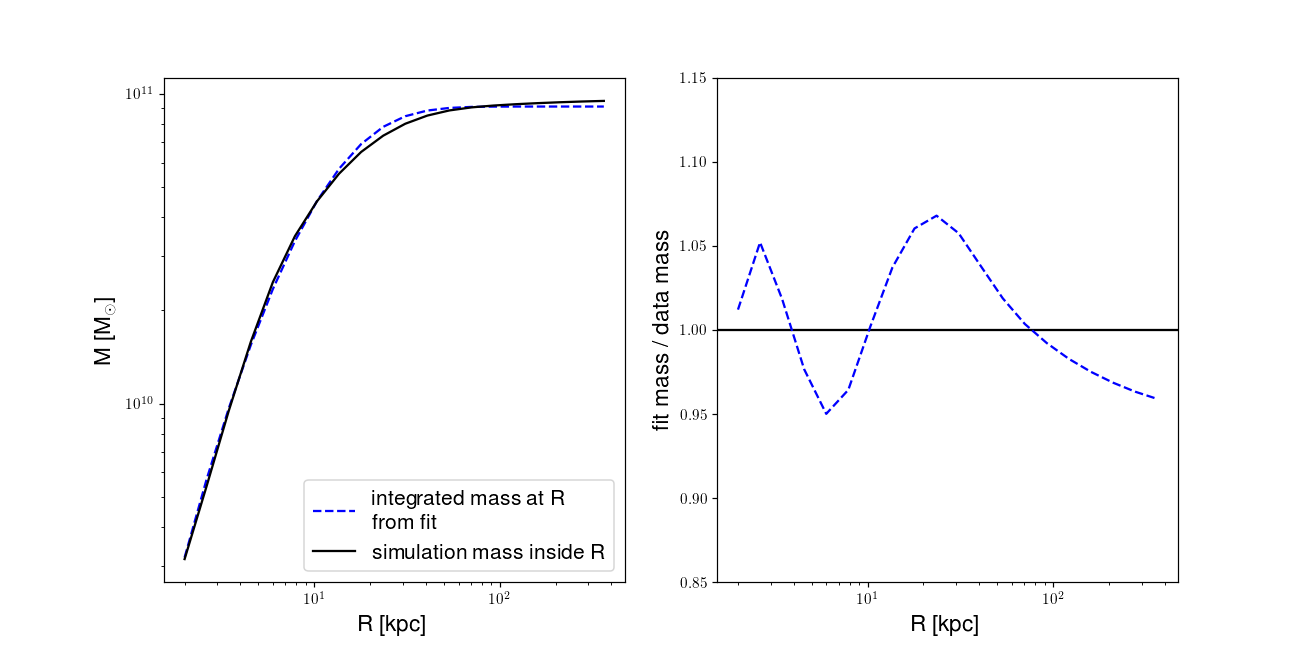

In [97]:
bulge = "Bulge: \n"
bulge += r"log($\rho _b$) = {0:.3f} $\pm$ {1:.3f}".format(mmass.values["B0"],mmass.errors["B0"])+"\n"
bulge += r"$r_0$ = {0:.3f} $\pm$ {1:.3f}".format(m2.values["r0"],m2.errors["r0"])+"\n"
bulge += r"$\alpha$ = {0:.3f} $\pm$ {1:.3f}".format(m2.values["al"],m2.errors["al"])+"\n"
bulge += r"r$_c$ = {0:.3f} $\pm$ {1:.3f}".format(m2.values["r_cut"],m2.errors["r_cut"])+"\n"
bulge += r"q = {0:.3f} $\pm$ {1:.3f}".format(m2.values["q"],m2.errors["q"])+"\n"

thin_disc = "Thin disc: \n"
thin_disc += r"log($\rho _d$) = {0:.3f} $\pm$ {1:.3f}".format(mmass.values["d0"],mmass.errors["d0"])+"\n"
thin_disc += r"$z_d$ = {0:.3f} $\pm$ {1:.3f}".format(m2.values["z_d"],m2.errors["z_d"])+"\n"
thin_disc += r"$R_d$ = {0:.3f} $\pm$ {1:.3f}".format(m2.values["Rd"],m2.errors["Rd"])+"\n"

thik_disc = "Thick disc: \n"
thik_disc += r"log($\rho _D$) = {0:.3f} $\pm$ {1:.3f}".format(mmass.values["D0"],mmass.errors["D0"])+"\n"
thik_disc += r"$z_D$ = {0:.3f} $\pm$ {1:.3f}".format(m2.values["z_D"],m2.errors["z_D"])+"\n"
thik_disc += r"$R_D$ = {0:.3f} $\pm$ {1:.3f}".format(m2.values["RD"],m2.errors["RD"])+"\n"



fig, ax = plt.subplots(1,2,figsize=[12,6])
fig.text(0.4,0.95,"Stars fit mass Mochima 2",fontsize=18)
fig.text(0.135,0.62,bulge,fontsize=12)
fig.text(0.3,0.58,thin_disc,fontsize=12)
fig.text(0.3,0.28,thik_disc,fontsize=12)

ax[0].set_xlabel("R [kpc]",fontsize=15)
ax[1].set_xlabel("R [kpc]",fontsize=15)
ax[0].set_ylabel(r"M [M$_{\odot}$]",fontsize=15)
ax[1].set_ylabel(r"fit mass / data mass",fontsize=15)

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_yscale('log')
#ax[1].set_yscale('log')
ax[1].set_ylim([0.85,1.15])
ax[0].plot(r_masses,level1,'b--',lw=1.5,label="integrated mass at R\nfrom fit")
ax[1].axhline(y=1,c='k')
ax[0].plot(r_masses,data_mass,'k',lw=1.5,label="simulation mass inside R")
ax[1].plot(r_masses,level1/data_mass,'b--',lw=1.5,label="ratio fit_mass/data_mass")
legend = ax[0].legend(loc='lower right', ncol=1, shadow=False, fontsize=14)
frame = legend.get_frame()
legend = ax[1].legend(loc='lower right', ncol=1, shadow=False, fontsize=14)
#frame = legend.get_frame()

In [98]:
print "###################################################"
print "##################### LUPM ########################"
print "################# Mochima Hydro ###################"
print "###################################################"
print "#################### Stars ########################"

print bulge
print thin_disc
print thik_disc

###################################################
##################### LUPM ########################
################# Mochima Hydro ###################
###################################################
#################### Stars ########################
Bulge: 
log($\rho _b$) = 8.562 $\pm$ 2.633
$r_0$ = 0.016 $\pm$ 0.000
$\alpha$ = 0.092 $\pm$ 0.000
r$_c$ = 1.699 $\pm$ 0.000
q = 0.499 $\pm$ 0.000

Thin disc: 
log($\rho _d$) = 8.941 $\pm$ 2.668
$z_d$ = 0.686 $\pm$ 0.000
$R_d$ = 1.993 $\pm$ 0.000

Thick disc: 
log($\rho _D$) = 8.158 $\pm$ 0.876
$z_D$ = 1.288 $\pm$ 0.000
$R_D$ = 4.987 $\pm$ 0.000



<IPython.core.display.Javascript object>


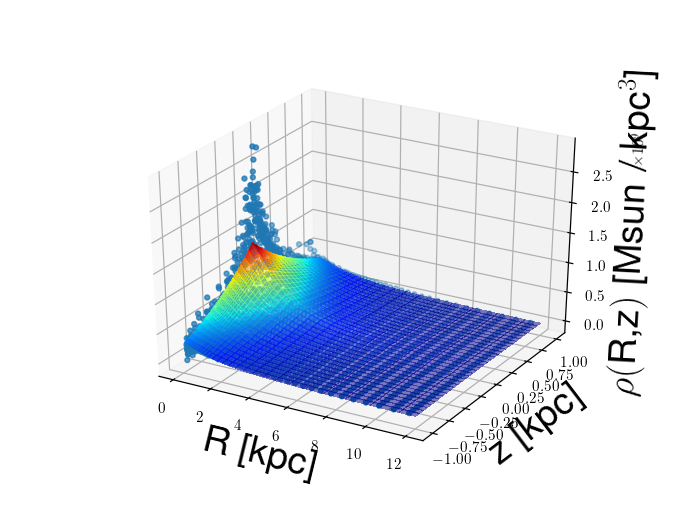

2346
2346
2346


In [99]:

bins = stars_bins
x = xedges#np.logspace(-1,np.log10(25),bins)
y = yedges#np.linspace(-6,6,bins/2.5)
U= np.meshgrid(x, y)


#Z = stars(U[0],U[1],m2.values['B_0'], m2.values['r0'], m2.values['al'] , m2.values['r_cut'],
#          m2.values['q'], m2.values['D_0'], m2.values['z_d'], m2.values['Rd'])
Z = stars(U[0],U[1],mmass.values['B0'], m2.values['r0'], m2.values['al'] , m2.values['r_cut'],
          m2.values['q'], mmass.values['d0'], m2.values['z_d'], m2.values['Rd'],
          mmass.values['D0'],m2.values['z_D'], m2.values['RD'])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.set_zscale('log')
#ax.set_zlim([0,1.2])

R_test = (x[1:] + x[:-1])/2
Z_test = (y[1:] + y[:-1])/2
X,Y = np.meshgrid(R_test, Z_test)
x_s = X.reshape(1,len(X)*len(X[0]))[0]
y_s = Y.reshape(1,len(Y)*len(Y[0]))[0]
dens = dens_hist.reshape(1,len(dens_hist)*len(dens_hist[0]))[0]
print len(x_s)
print len(y_s)
print len(dens)
ax.set_xlabel("R [kpc]",fontsize=25)
my_col = cm.jet(Z/Z.max())
ax.set_ylabel("z [kpc]",fontsize=25)
ax.set_zlabel(r"$\rho($R,z$)$ [Msun / kpc$^3$]",fontsize=25)

ax.scatter(x_s, y_s,dens,marker='.',s=40)
surf = ax.plot_surface(U[0], U[1], Z, cmap=cm.coolwarm, facecolors = my_col,alpha=0.5,
                       linewidth=0, antialiased=False)

<IPython.core.display.Javascript object>


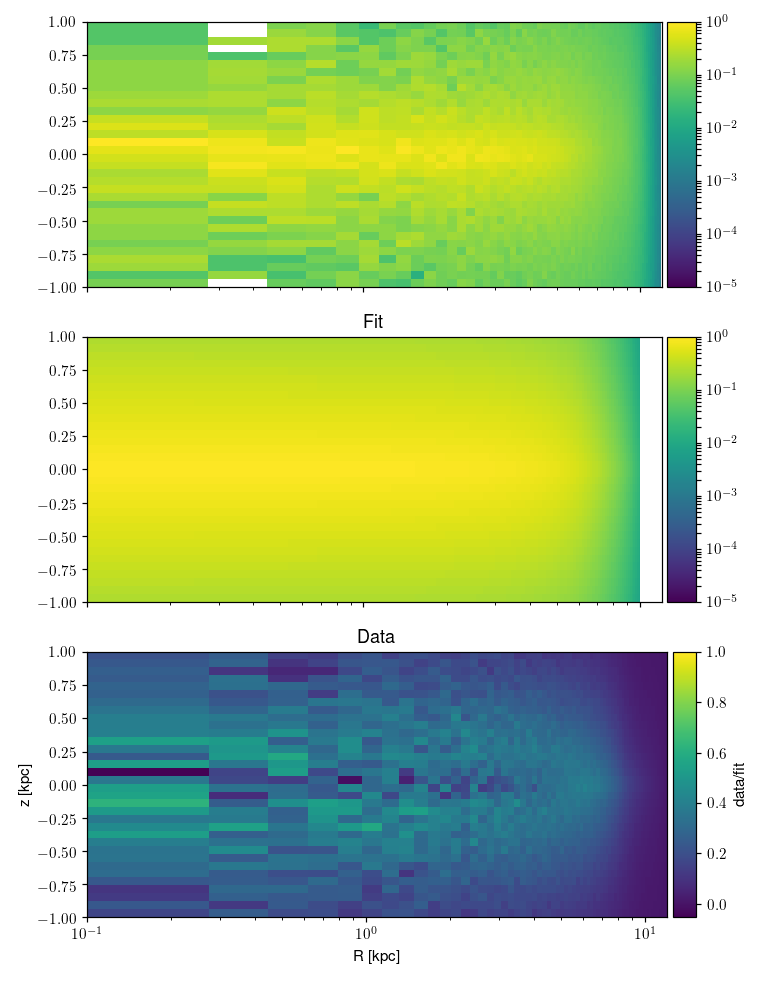

In [100]:
bins = stars_bins -1

x = np.logspace(-1,np.log10(10),bins)
y = np.linspace(-1,1,bins/2)

#x = np.logspace(-1,np.log10(25),bins)
#y = np.linspace(-6,6,(bins/2.5))
U= np.meshgrid(x, y)



Z = stars(U[0],U[1],mmass.values['B0'], m2.values['r0'], m2.values['al'] , m2.values['r_cut'],m2.values['q'],
          mmass.values['d0'], m2.values['z_d'], m2.values['Rd'],
          mmass.values['D0'], m2.values['z_D'], m2.values['RD'])




fig ,[ax,ax1,ax2] = plt.subplots(3,1,figsize=[7,9],sharex=True, sharey=True)


plt.tight_layout(h_pad=2)
ax.set_xscale('log')
real = ax.imshow(dens_hist / dens_hist.max(), interpolation='nearest', origin='low',aspect='auto',
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],norm=LogNorm(vmin=1e-5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax)#,orientation='horizontal')



ax1.set_title("Fit")
ax1.set_xscale('log')



fit = ax1.imshow(Z/Z.max(), interpolation='nearest', origin='low',aspect='auto',
                  extent=[x[0], x[-1], y[0], y[-1]],norm=LogNorm(vmin=1e-5))
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax)


#print "fit  : max = {0:.3e}, min = {1:.3e}".format(Z.max(),Z.min())##print "data : max = {0:.3e}, min = {1:.3e}".format(dens_hist.max(),dens_hist.min())
ratio =  ((Z/Z.max())-(dens_hist/dens_hist.max()))#/(dens_hist/dens_hist.max())
#ratio =  np.abs(Z-dens_hist)/(dens_hist)

ax2.set_title("Data")
ax2.set_xlabel("R [kpc]")
ax2.set_ylabel("z [kpc]")
ax2.set_xscale('log')

real = ax2.imshow(ratio, interpolation='nearest', origin='low', vmax=1,aspect='auto',
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])#,norm=LogNorm(vmax=1e0))
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="4%", pad=0.05)
cbar = plt.colorbar(real,cax=cax,label='data/fit')
fig.tight_layout()

In [103]:
# R array logarithmic Bining
r_p_st = np.logspace(np.log10(2*hsml),np.log10(2.5*myhydro.r200),100)
# histogram of dm particles per logarithmic bin
n_hydro_st,r_st = np.histogram(myhydro.st.r,bins=r_p_st, weights=myhydro.st.mass)
# edges of bins
r1,r2 =r_st[:-1],r_st[1:]
# shell's volume
vol = 4.* np.pi * ((r2**3)-(r1**3)) / 3.
# density per shell
profilehydro_st = n_hydro_st/vol
# center of bins
r_st = (r_p_st[:-1]+r_p_st[1:])/2.
bin_size= (r_p_st[:-1]-r_p_st[1:])/2.
rr_st = r_st




path2file = "/home/arturo/Documents/LAM/LAM2LUPM/dataFiles/profiles/"
outfile = open(path2file+hydro.namenospace+"_hydro_st_profile_cphi.dat","w")
outfile.write("# SIM: "+ hydro.namenospace+" hydro\n")
outfile.write("# center: minima of Potential ")
outfile.write("# date: {0} \n".format(datetime.datetime.now()))
outfile.write("# r200: "+str(myhydro.r200)+" kpc \n")
outfile.write("# fit results: \n")
outfile.write(  "# Bulge: \n")
outfile.write( "# log( rho _b ) = {0:.3f}  \pm  {1:.3f}".format(mmass.values["B0"],mmass.errors["B0"])+"\n")
outfile.write( "# r_0  = {0:.3f}".format(m2.values["r0"],m2.errors["r0"])+"\n")
outfile.write( "# alpha  = {0:.3f}".format(m2.values["al"],m2.errors["al"])+"\n")
outfile.write( "# r _c  = {0:.3f}".format(m2.values["r_cut"],m2.errors["r_cut"])+"\n")
outfile.write( "# q = {0:.3f} ".format(m2.values["q"],m2.errors["q"])+"\n")
outfile.write( "# Thin disc: \n")
outfile.write("# log( \rho _d ) = {0:.3f}  \pm  {1:.3f}".format(mmass.values["d0"],mmass.errors["d0"])+"\n")
outfile.write("# z_d  = {0:.3f}".format(m2.values["z_d"],m2.errors["z_d"])+"\n")
outfile.write("# R_d  = {0:.3f}".format(m2.values["Rd"],m2.errors["Rd"])+"\n")
outfile.write(   "# Thick disc: \n")
outfile.write(  "# log( \rho _D ) = {0:.3f}  \pm  {1:.3f}".format(mmass.values["D0"],mmass.errors["D0"])+"\n")
outfile.write(  "# z_D  = {0:.3f}".format(m2.values["z_D"],m2.errors["z_D"])+"\n")
outfile.write(  "# R_D  = {0:.3f}".format(m2.values["RD"],m2.errors["RD"])+"\n")
outfile.write("# FORMAT:\n")
outfile.write("#   r  ,     rho     ,    sigma,     sigma_log \n")
outfile.write("# [kpc], [Msun/kpc^3], [Msun/kpc^3], log([Msun/kpc^3])  \n")
for i in range(len(r)):
    outfile.write("{0:.3f} , {1:.4e} \n".format(r_st[i],profilehydro_st[i]))

outfile.close()

# gas

In [108]:
log_hsml = np.log10(myhydro.gs.hsml.min())

In [109]:
gs_bins=40
edge = 20
zedge = edge/40.
x_gs = np.logspace(-0.5,np.log10(edge),gs_bins)
y_gs = np.linspace(-zedge,zedge,gs_bins)
dens_hist_gs = np.zeros([len(y_gs)-1,len(x_gs)-1])
sigma_gs = np.zeros([len(y_gs)-1,len(x_gs)-1])
for i in range(len(x_gs[:-1])):
    for j in range(len(y_gs[:-1])):
        Rcon = (myhydro.gs.R >= x_gs[i] )&(myhydro.gs.R < x_gs[i+1] )
        Zcon = (myhydro.gs.pos3d[:,2] >= y_gs[j])&(myhydro.gs.pos3d[:,2] < y_gs[j+1])
        mass = np.sum(myhydro.gs.mass[np.where(Rcon&Zcon)])
        sigma_gs[j][i] = np.std(myhydro.gs.rho[np.where(Rcon&Zcon)])
        volume = np.pi * (y_gs[j+1]-y_gs[j]) * (x_gs[i+1]**2 - x_gs[i]**2)
        dens_hist_gs [j][i] = mass / volume 
    
    


In [110]:
dens_hist_gs = np.nan_to_num(dens_hist_gs)

<IPython.core.display.Javascript object>


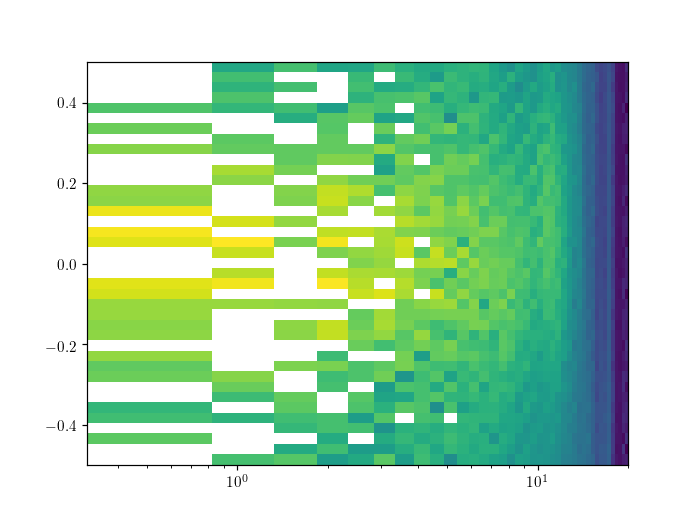

In [111]:
fig, ax = plt.subplots()
ax.set_xscale('log')
real =  plt.imshow(dens_hist_gs, interpolation='nearest', origin='low',norm=mpl.colors.LogNorm(),
           extent=[x_gs[0], x_gs[-1], y_gs[0], y_gs[-1]])

#cbar = plt.colorbar(real)#,orientation='horizontal')

In [112]:
#def gas(R,z,D_0,z_d,Rm,Rd):        
#    return (10**D_0) * np.exp(- (Rm / R) - (R / Rd)) / (np.cosh(z /2./ z_d))**2


def gas(R,z,D_0,z_d,Rd):
        
    return (10**D_0) * np.exp( - (R / Rd)) / (np.cosh(z /2./ z_d))**2

R_array = (x_gs[1:] + x_gs[:-1])/2
Z_array = (y_gs[1:] + y_gs[:-1])/2

R , Z = np.meshgrid(R_array,Z_array)


def chi2_gas(D_0,z_d,Rd):
    chi2_array =np.array([])
    expected = gas(R,Z,D_0,z_d,Rd)
    observed = dens_hist_gs
    c = ((observed) - (expected))**2# / sigma_gs**2
    chi2_array = np.append(chi2_array,c)
    c_val = np.nansum(chi2_array)
    return (c_val)


def mass_check_gas(D_0,z_d,Rd):
    xe, ye = np.linspace(0,edge,gs_bins ),np.linspace(-edge/15.,edge/15.,gs_bins)
    R_test,Z_test = (xe[1:] + xe[:-1])/2 , (ye[1:] + ye[:-1])/2
    U = np.meshgrid(R_test,Z_test)
    rho = 2. * np.pi * R_test * gas(U[0],U[1],D_0,z_d,Rd)
    I = np.zeros( len(rho) )
    for i in range(len(rho)):
        I[i] = np.trapz( rho[i], R_test )
    F = np.trapz( I, Z_test )
    data_in = np.sum(myhydro.gs.mass[np.where((myhydro.gs.R<edge)&(np.abs(myhydro.gs.pos3d[:,2])<edge/10.))])
    N = len(myhydro.gs.mass[np.where((myhydro.gs.R<edge)&(np.abs(myhydro.gs.pos3d[:,2])<edge/10.))])
    diff = np.abs(np.log10(data_in) - np.log10(F))
    return  diff

In [113]:
mg1=Minuit(chi2_gas, 
           D_0=8.4,    error_D_0=0.7,     limit_D_0=(8.5,10.5),
           z_d=0.6,  error_z_d=0.1,  limit_z_d=(0.001,2),
           Rd=2.5,     error_Rd=0.1,        limit_Rd=(0.3,4))
mg1.migrad();

err = 0.01
upp = 1.5
low = 0.5
mg2=Minuit(mass_check_gas, 
         D_0=mg1.values['D_0'], error_D_0=mg1.values['D_0']*err, limit_D_0=(mg1.values['D_0']*low,mg1.values['D_0']*upp),
         z_d=mg1.values['z_d'], error_z_d=mg1.values['z_d']*err,  limit_z_d=(mg1.values['z_d']*low,mg1.values['z_d']*upp),
         Rd=mg1.values['Rd'], error_Rd=mg1.values['Rd']*err, limit_Rd=(mg1.values['Rd']*low,mg1.values['Rd']*upp))

mg2.migrad();

FCN = 1.30071085782e+21 
 TOTAL NCALL = 181 
 NCALLS = 178 
 
 
 EDM = 47361794.0896 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 D_0 
 9.91094 
 4.44977e-11 
 
 
 8.5 
 10.5 
 No 
 
 
 1 
 z_d 
 0.0831075 
 4.2386e-12 
 
 
 0.001 
 2 
 No 
 
 
 2 
 Rd 
 0.533208 
 5.18655e-11 
 
 
 0.3 
 4 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $D_{0}$ & 9.91094 & 4.44977e-11 & & & 8.5 & 10.5 & No\\
\hline
1 & $z_{d}$ & 0.0831075 & 4.2386e-12 & & & 0.001 & 2 & No\\
\hline
2 & Rd & 0.533208 & 5.18655e-11 & & & 0.3 & 4 & No\\
\hline
\end{tabular}

FCN = 0.000118137463012 
 TOTAL NCALL = 128 
 NCALLS = 117 
 
 
 EDM = 0.101000244646 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 D_0 
 10.3463 
 0.076427 
 
 
 4.95547 
 14.8664 
 No 
 
 
 1 
 z_d 
 0.0825994 
 0.0619225 
 
 
 0.0415538 
 0.124661 
 No 
 
 
 2 
 Rd 
 0.529979 
 0.153992 
 
 
 0.266604 
 0.799813 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $D_{0}$ & 10.3463 & 0.076427 & & & 4.95546953109 & 14.8664 & No\\
\hline
1 & $z_{d}$ & 0.0825994 & 0.0619225 & & & 0.0415537655386 & 0.124661 & No\\
\hline
2 & Rd & 0.529979 & 0.153992 & & & 0.266604198733 & 0.799813 & No\\
\hline
\end{tabular}

In [114]:

def mass_integrated_gas(edge):
    """
    integraties the amount of mass obtained by the gas fit
     gas(R,z,D_0,z_d,Rd)
    """
    bins = 101
    zedge = edge/10.
    xe = np.linspace(0,edge,bins)
    ye = np.linspace(-zedge,zedge,bins)
    R_test = (xe[1:] + xe[:-1])/2
    Z_test = (ye[1:] + ye[:-1])/2
    U = np.meshgrid(R_test,Z_test)
    rho = 2. * np.pi * U[0] * gas(U[0],U[1],mg2.values['D_0'], mg2.values['z_d'] , mg2.values['Rd'])

    def integrand(R,z,D_0,z_d,Rd):
        return 2. * np.pi * R * gas(R,z,D_0,z_d,Rd)

    j = dblquad(integrand, -zedge, zedge , lambda x: 0, lambda x: edge, args=(mg1.values['D_0'], mg1.values['z_d'], mg1.values['Rd']))

    i = dblquad(integrand, -zedge, zedge , lambda x: 0, lambda x: edge, args=(mg2.values['D_0'], mg2.values['z_d'] , mg2.values['Rd']))
    
    F = j[0] #firs level fit
    F2 = i[0] # second level fit
    return F , F2
#print "Fit  =  {0:.5e} dens constrain 1dn level fit".format(F2)
#print "Fit  =  {0:.5e} mass constrain 2dn level fit".format(F)
#print "data = ",np.sum(myhydro.st.mass[np.where((myhydro.st.R<edge)&(np.abs(myhydro.st.pos3d[:,2])<zedge))])
get_masses_gs = np.vectorize(mass_integrated_gas)
get_mass_data_gs = np.vectorize(lambda u :np.sum(myhydro.gs.mass[np.where((myhydro.gs.R<u)&(np.abs(myhydro.gs.pos3d[:,2])<u/10.))]))


In [115]:
def mass_gas(edge,d0,zd,rd):
    """
    integraties the amount of mass obtained by the gas fit
     gas(R,z,D_0,z_d,Rd)
    """
    bins = 101
    zedge = edge/10.
    xe = np.linspace(0,edge,bins)
    ye = np.linspace(-zedge,zedge,bins)
    R_test = (xe[1:] + xe[:-1])/2
    Z_test = (ye[1:] + ye[:-1])/2
    U = np.meshgrid(R_test,Z_test)

    def integrand(R,z,D_0,z_d,Rd):
        return 2. * np.pi * R * gas(R,z,D_0,z_d,Rd)

    j = dblquad(integrand, -zedge, zedge , lambda x: 0, lambda x: edge, args=(d0,zd,rd))
    
    F = j[0] #firs level fit
    return F 

get_mass_GAs = np.vectorize(mass_gas)


In [116]:
## BEWARE!!! the 30 is because of the shape of the gas density it explodes after r=30kpc
r_masses = np.logspace(np.log10(2),np.log10(30),20)
glevel1, glevel2 = get_masses_gs(r_masses)
gdata_mass = get_mass_data_gs(r_masses)

In [117]:
def chimass_gs(d0,zs,r0):
    c = np.log10(get_mass_GAs(r_masses,d0,zs,r0))-np.log10(gdata_mass)
    return np.sum(c**2)


mmass_gs=Minuit(chimass_gs, 
         d0=9,  error_d0=0.2,     limit_d0=(6,10.7),
         zs=.1,  error_zs=0.01,     limit_zs=(0.01,1.5),
         r0=3.5,  error_r0=0.1,     limit_r0=(1,8))
#         print_level=0)
mmass_gs.migrad();

FCN = 0.0199160751294 
 TOTAL NCALL = 78 
 NCALLS = 78 
 
 
 EDM = 0.00010684294809 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 d0 
 9.34981 
 1.06429 
 
 
 6 
 10.7 
 No 
 
 
 1 
 zs 
 0.136385 
 1.10031 
 
 
 0.01 
 1.5 
 No 
 
 
 2 
 r0 
 1.186 
 6.21581 
 
 
 1 
 8 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & d0 & 9.34981 & 1.06429 & & & 6.0 & 10.7 & No\\
\hline
1 & zs & 0.136385 & 1.10031 & & & 0.01 & 1.5 & No\\
\hline
2 & r0 & 1.186 & 6.21581 & & & 1.0 & 8 & No\\
\hline
\end{tabular}

In [118]:
gas_fit_from_mass = get_mass_GAs(r_masses,mmass_gs.values['d0'],mmass_gs.values['zs'],mmass_gs.values['r0'])

<IPython.core.display.Javascript object>


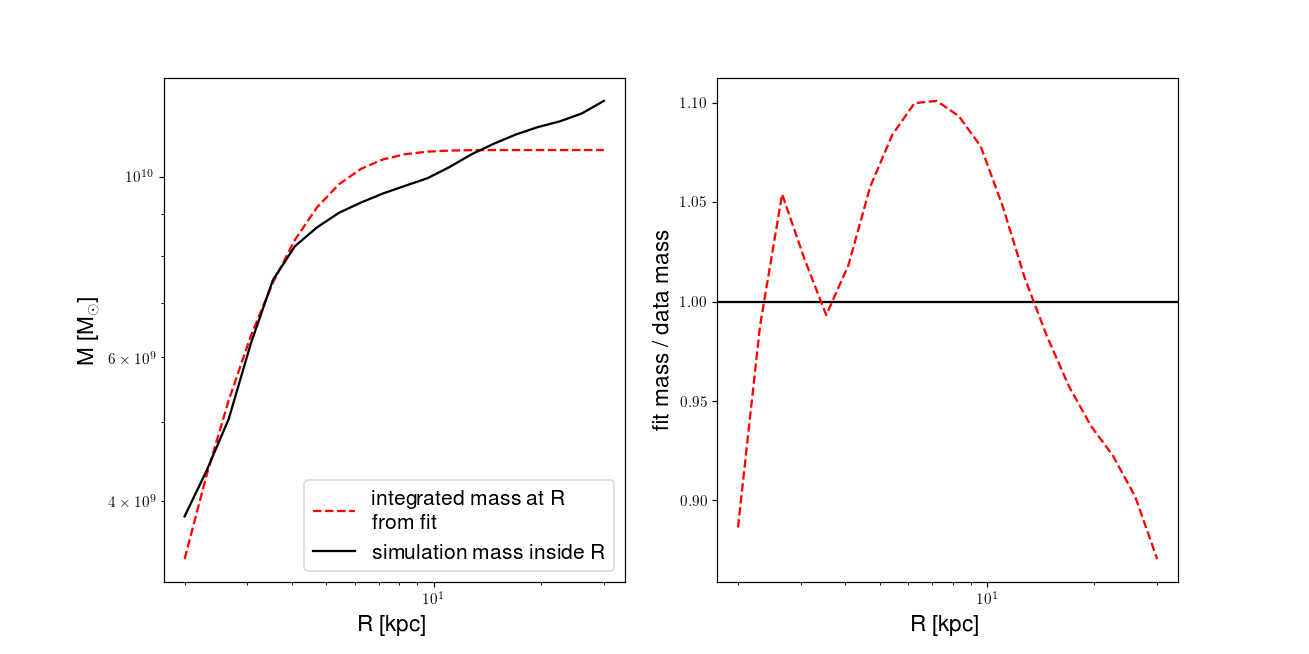

In [119]:
texto = "Gas disc results: \n"
texto += r"log($\rho _d$) =$ {0:.3f} \pm {1:.3f}$".format(mmass_gs.values["d0"],mmass_gs.errors["d0"])+"\n"
texto += r"$z_d$ =$ {0:.3f} \pm {1:.3f}$".format(mmass_gs.values["zs"],mmass_gs.errors["zs"])+"\n"
texto += r"$R_d$ =$ {0:.3f} \pm {1:.3f}$".format(mmass_gs.values["r0"],mmass_gs.errors["r0"])+"\n"

fig, ax = plt.subplots(1,2,figsize=[12,6])
fig.text(0.4,0.95,"Gas fit mass Mochima 2",fontsize=18)
fig.text(0.3,0.35,texto,fontsize=12)
ax[0].set_xlabel("R [kpc]",fontsize=15)
ax[1].set_xlabel("R [kpc]",fontsize=15)
ax[0].set_ylabel(r"M [M$_{\odot}$]",fontsize=15)
ax[1].set_ylabel(r"fit mass / data mass",fontsize=15)

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_yscale('log')
#ax[1].set_yscale('log')
#ax[1].set_ylim([0.85,1.15])
#ax[0].plot(r_masses,glevel1,'b--')
ax[1].axhline(y=1,c='k')
ax[0].plot(r_masses, gas_fit_from_mass ,'r--',lw=1.5,label="integrated mass at R\nfrom fit")
ax[0].plot(r_masses,gdata_mass,'k',lw=1.5,label="simulation mass inside R")
ax[1].plot(r_masses, gas_fit_from_mass/gdata_mass,'r--',lw=1.5,label="ratio fit_mass/data_mass")
#ax[1].plot(r_masses,glevel1/data_mass,'b--')
legend = ax[0].legend(loc='lower right', ncol=1, shadow=False, fontsize=14)
frame = legend.get_frame()
legend = ax[1].legend(loc='upper right', ncol=1, shadow=False, fontsize=14)
frame = legend.get_frame()

In [120]:
print "###################################################"
print "##################### LUPM ########################"
print "################# Mochima Hydro ###################"
print "###################################################"
print "####################  GAS #########################"

print texto

###################################################
##################### LUPM ########################
################# Mochima Hydro ###################
###################################################
####################  GAS #########################
Gas disc results: 
log($\rho _d$) =$ 9.350 \pm 1.064$
$z_d$ =$ 0.136 \pm 1.100$
$R_d$ =$ 1.186 \pm 6.216$



<IPython.core.display.Javascript object>


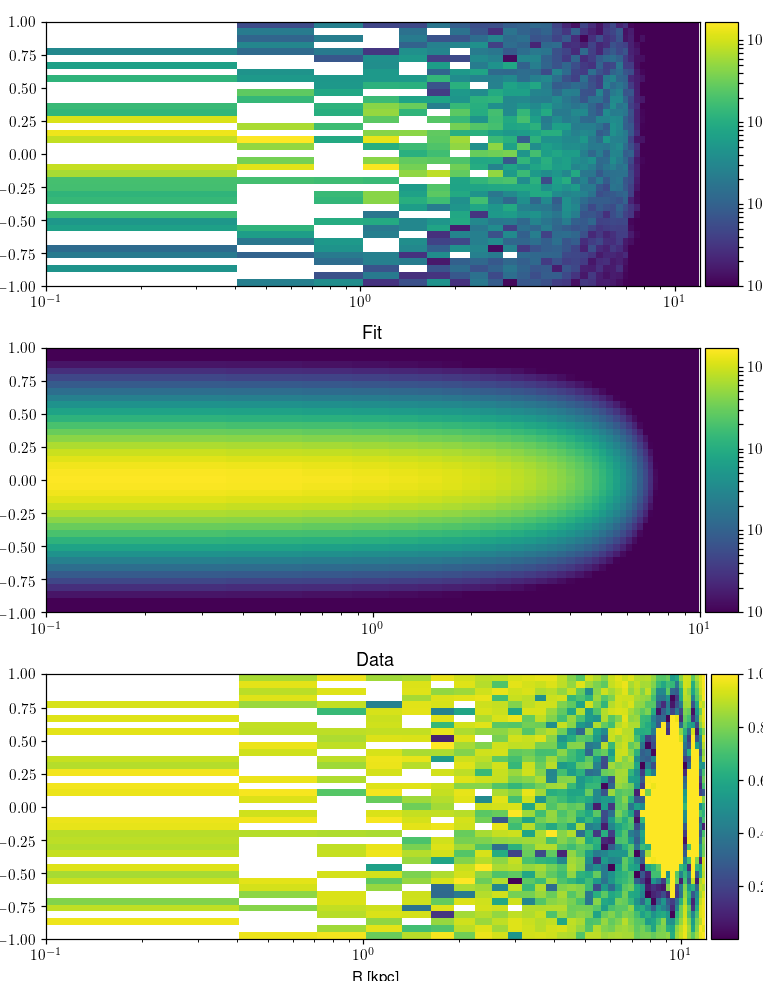

fit  : max = 2.700e+08, min = 3.818e+02
data : max = 1.699e+10, min = 0.000e+00


In [121]:
bins = gs_bins -1


edge = 20
zedge = edge/40.
x_gs = np.logspace(-0.5,np.log10(edge),bins)
y_gs = np.linspace(-zedge,zedge,bins)


x = np.logspace(-1,np.log10(10),bins)
y = np.linspace(-1,1,bins/2)

#x = np.logspace(-1,np.log10(25),bins)
#y = np.linspace(-6,6,(bins/2.5))
U= np.meshgrid(x_gs, y_gs)


"""
Z = gas(U[0],U[1],9.3, 0.2 , 1.2)
"""
#"""
Z = gas(U[0],U[1],mg2.values['D_0'], 0.5 , mg2.values['Rd'])
#"""



fig ,[ax,ax1,ax2] = plt.subplots(3,1,figsize=[7,9])


plt.tight_layout(h_pad=2)
ax.set_xscale('log')
real = ax.imshow(dens_hist_gs, interpolation='nearest', origin='low',aspect='auto',
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],norm=LogNorm(vmin=1e7))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax)#,orientation='horizontal')



ax1.set_title("Fit")
ax1.set_xscale('log')


Z = gas(U[0],U[1],8.5, 0.1 , 2.)

fit = ax1.imshow(Z, interpolation='nearest', origin='low',aspect='auto',
                  extent=[x[0], x[-1], y[0], y[-1]],norm=LogNorm(vmin=1e7))
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax)

#ax.set_title("Data")

#real = ax.imshow(dens_hist, interpolation='nearest', origin='low',aspect='auto',
#                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)
#cbar = plt.colorbar(real,cax=cax)#,orientation='horizontal')

print "fit  : max = {0:.3e}, min = {1:.3e}".format(Z.max(),Z.min())
print "data : max = {0:.3e}, min = {1:.3e}".format(dens_hist_gs.max(),dens_hist.min())
ratio =  np.abs(Z-dens_hist_gs)/dens_hist_gs

ax2.set_title("Data")
ax2.set_xlabel("R [kpc]")
ax2.set_ylabel("z [kpc]")
ax2.set_xscale('log')

real = ax2.imshow(ratio, interpolation='nearest', origin='low', vmax=1,aspect='auto',
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])#,norm=LogNorm(vmax=1e0))
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="4%", pad=0.05)
cbar = plt.colorbar(real,cax=cax,label='data/fit')

In [122]:
# R array logarithmic Bining
r_p_gs = np.logspace(np.log10(2*hsml),np.log10(2.5*myhydro.r200),100)
# histogram of dm particles per logarithmic bin
n_hydro_gs,r_gs = np.histogram(myhydro.gs.r,bins=r_p_gs, weights=myhydro.gs.mass)
# edges of bins
r1,r2 =r_gs[:-1],r_gs[1:]
# shell's volume
vol = 4.* np.pi * ((r2**3)-(r1**3)) / 3.
# density per shell
profilehydro_gs = n_hydro_gs/vol
# center of bins
r_gs = (r_p_gs[:-1]+r_p_gs[1:])/2.
bin_size= (r_p_gs[:-1]-r_p_gs[1:])/2.
rr_gs = r_gs




path2file = "/home/arturo/Documents/LAM/LAM2LUPM/dataFiles/profiles/"
outfile = open(path2file+hydro.namenospace+"_hydro_gs_profile_cphi.dat","w")
outfile.write("# SIM: "+ hydro.namenospace+" hydro\n")
outfile.write("# center: minima of Potential ")
outfile.write("# date: {0} \n".format(datetime.datetime.now()))
outfile.write("# r200: "+str(myhydro.r200)+" kpc \n")
outfile.write("# fit results: \n")
outfile.write(  "# Bulge: \n")
outfile.write( "# log( rho _b ) = {0:.3f}  \pm  {1:.3f}".format(mmass.values["B0"],mmass.errors["B0"])+"\n")
outfile.write( "# r_0  = {0:.3f}".format(m2.values["r0"],m2.errors["r0"])+"\n")
outfile.write( "# alpha  = {0:.3f}".format(m2.values["al"],m2.errors["al"])+"\n")
outfile.write( "# r _c  = {0:.3f}".format(m2.values["r_cut"],m2.errors["r_cut"])+"\n")
outfile.write( "# q = {0:.3f} ".format(m2.values["q"],m2.errors["q"])+"\n")
outfile.write( "# Thin disc: \n")
outfile.write("# log( \rho _d ) = {0:.3f}  \pm  {1:.3f}".format(mmass.values["d0"],mmass.errors["d0"])+"\n")
outfile.write("# z_d  = {0:.3f}".format(m2.values["z_d"],m2.errors["z_d"])+"\n")
outfile.write("# R_d  = {0:.3f}".format(m2.values["Rd"],m2.errors["Rd"])+"\n")
outfile.write(   "# Thick disc: \n")
outfile.write(  "# log( \rho _D ) = {0:.3f}  \pm  {1:.3f}".format(mmass.values["D0"],mmass.errors["D0"])+"\n")
outfile.write(  "# z_D  = {0:.3f}".format(m2.values["z_D"],m2.errors["z_D"])+"\n")
outfile.write(  "# R_D  = {0:.3f}".format(m2.values["RD"],m2.errors["RD"])+"\n")
outfile.write("# FORMAT:\n")
outfile.write("#   r  ,     rho     ,    sigma,     sigma_log \n")
outfile.write("# [kpc], [Msun/kpc^3], [Msun/kpc^3], log([Msun/kpc^3])  \n")
for i in range(len(r)):
    outfile.write("{0:.3f} , {1:.4e} \n".format(r_gs[i],profilehydro_gs[i]))

outfile.close()

# S and T

In [75]:
# S and T

get_mat =  np.vectorize(nbe.m_matrix_for_r)

r = np.linspace(myhydro.gs.hsml.min(),2*myhydro.r200,300)
M_dm = np.array([nbe.m_matrix_for_r(myhydro,'halo',i)[0] for i in r])
M_st = np.array([nbe.m_matrix_for_r(myhydro,'stars',i)[0] for i in r])
a_dm, b_dm, c_dm = np.sqrt(M_dm[:,0,0]), np.sqrt(M_dm[:,1,1]), np.sqrt(M_dm[:,2,2])
a_st, b_st, c_st = np.sqrt(M_st[:,0,0]), np.sqrt(M_st[:,1,1]), np.sqrt(M_st[:,2,2])
S_dm = c_dm/a_dm
T_dm = ((a_dm**2) - (b_dm**2))/((a_dm**2) -(c_dm**2)) 
S_st = c_st/a_st
T_st = ((a_st**2) - (b_st**2))/((a_st**2) -(c_st**2)) 


outputing = open(path2file+hydro.namenospace+"_S_and_T_phicen.txt","w")
outputing.write("# "+simname+" ellipticity parameters\n")
outputing.write("# center: minima of potential\n")
outputing.write("# r200 = {0:.2f} kpc\n".format(myhydro.r200))
outputing.write("# format:\n")
outputing.write("# r (kpc), S , T\n")
for i in range(len(T_dm)):
    outputing.write("{0:.2f} {1:.6f} {2:.6f} \n".format(r[i],S_dm[i],T_dm[i]))

outputing.close()


## DMO

r = np.linspace(4*myhydro.gs.hsml.min(),2*myDMO.r200,300)
M_dm = np.array([nbe.m_matrix_for_r(myDMO,'halo',i)[0] for i in r])
a_dm, b_dm, c_dm = np.sqrt(M_dm[:,0,0]), np.sqrt(M_dm[:,1,1]), np.sqrt(M_dm[:,2,2])
S_dm = c_dm/a_dm
T_dm = ((a_dm**2) - (b_dm**2))/((a_dm**2) -(c_dm**2)) 


outputing = open(path2file+dmo.namenospace +"_S_and_T_DMO_phicen.txt","w")
outputing.write("# "+dmo.name+" ellipticity parameters\n")
outputing.write("# center: minima of potential \n")
outputing.write("# r200 = {0:.2f} kpc\n".format(myhydro.r200))
outputing.write("# format:\n")
outputing.write("# r (kpc), S , T\n")
for i in range(len(T_dm)):
    outputing.write("{0:.2f} {1:.6f} {2:.6f} \n".format(r[i],S_dm[i],T_dm[i]))

outputing.close()

In [76]:
## hydro
rmin, rmax, cesh = 7.5,8.5,8
selection = np.where((myhydro.dm.r>rmin)&(myhydro.dm.r<rmax))
hist, bins = np.histogram(myhydro.dm.v[selection],bins=40,normed=1)
bins_c = (bins[1:]+bins[:-1])/2.

outputing = open(path2file+hydro.namenospace+"_vdf_"+str(cesh)+"_hydro_phicen.txt","w")
outputing.write("# "+simname+" vdf\n")
outputing.write("# center: minima of potential\n")
outputing.write("# rmin = "+str(rmin)+" kpc, rmax = "+str(rmax)+" kpc \n")
outputing.write("# r200 = {0:.2f} kpc\n".format(myhydro.r200))
outputing.write("# format:\n")
outputing.write("# bin_center km/s, vdf \n")
for i in range(len(bins_c)):
    outputing.write("{0:.2f} {1:.6f} \n".format(bins_c[i], hist[i]))

outputing.close()

## DMO

rmin, rmax, cesh = 7.5,8.5,8
selection = np.where((myDMO.dm.r>rmin)&(myDMO.dm.r<rmax))
hist, bins = np.histogram(myDMO.dm.v[selection],bins=40,normed=1)
bins_c = (bins[1:]+bins[:-1])/2.

outputing = open(path2file+dmo.namenospace+"_vdf_"+str(cesh)+"_DMO_phicen.txt","w")
outputing.write("# "+simname+" vdf\n")
outputing.write("# center: minima of potential\n")
outputing.write("# rmin = "+str(rmin)+" kpc, rmax = "+str(rmax)+" kpc \n")
outputing.write("# r200 = {0:.2f} kpc\n".format(myDMO.r200))
outputing.write("# format:\n")
outputing.write("# bin_center km/s, vdf \n")
for i in range(len(bins_c)):
    outputing.write("{0:.2f} {1:.6f} \n".format(bins_c[i], hist[i]))

outputing.close()

# COMPARISON

<IPython.core.display.Javascript object>


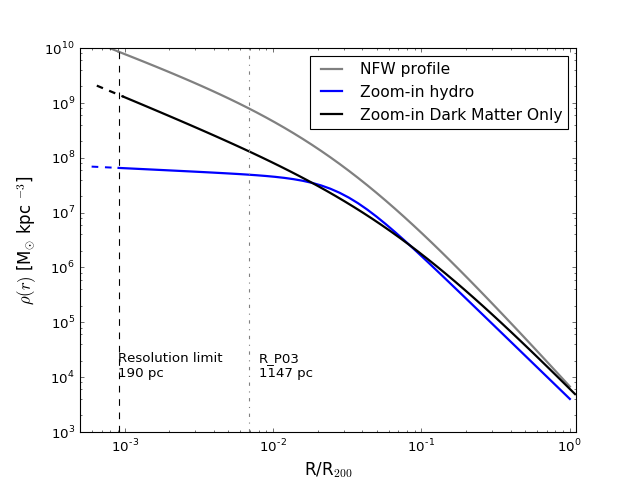

In [366]:
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim([0.0005,1.1])
ax.set_ylim([1e3,1e10])
ax.set_xlabel(r'R/R$_{200}$',fontsize=15)
ax.set_ylabel(r'$\rho(r)$ [M$_{\odot}$ kpc $^{-3}$]',fontsize=15)
r_in = np.logspace(-1,np.log10(myhydro.gs.hsml.min()))
r_out = np.logspace(np.log10(myhydro.gs.hsml.min()),np.log10(myhydro.r200))
##NFW
ax.plot(r_in/myhydro.r200,(abg_profile(r_in,8.45,m_rho_hydro.values['r_s'],1,3,1)),
        color="gray",ls="-",lw=1.8)
ax.plot(r_out/myhydro.r200,(abg_profile(r_out,8.45,m_rho_hydro.values['r_s'],1,3,1)),
        color="gray",ls="-",lw=2,label="NFW profile")

## Hydro

ax.plot(r_in/myhydro.r200,(abg_profile(r_in,m_rho_hydro.values['po'] ,m_rho_hydro.values['r_s'],m_rho_hydro.values['al'],m_rho_hydro.values['be'],m_rho_hydro.values['ga'])),
        "b--",lw=1.8)
ax.plot(r_out/myhydro.r200,(abg_profile(r_out,m_rho_hydro.values['po'] ,m_rho_hydro.values['r_s'],m_rho_hydro.values['al'],m_rho_hydro.values['be'],m_rho_hydro.values['ga'])),
        "b-",lw=2,label = "Zoom-in hydro")
#DMO
ax.plot(r_in/myDMO.r200,(abg_profile(r_in,m_rho.values['po'] ,m_rho.values['r_s'],m_rho.values['al'],m_rho.values['be'],m_rho.values['ga'])),
        "k--",lw=2)
ax.plot(r_out/myDMO.r200,(abg_profile(r_out,m_rho.values['po'] ,m_rho.values['r_s'],m_rho.values['al'],m_rho.values['be'],m_rho.values['ga'])),
        "k-",lw=2,label = "Zoom-in Dark Matter Only")
ax.axvline(myhydro.gs.hsml.min()/myhydro.r200,color="k",linestyle="--")
ax.text(9e-4,1e4,"Resolution limit\n190 pc")
ax.axvline(R_P03/myhydro.r200,color="gray",linestyle="-.")
ax.text(8e-3,1e4,"R_P03\n{0} pc".format(int(R_P03*1e3)))

legend = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=14)
frame = legend.get_frame()

In [368]:
def maxw(v,sigma):
    N = np.sqrt(32 * np.pi) * v**2 / sigma**3
    return N * np.exp(- v**2 / 2. / sigma**2)
get_maxw = np.vectorize(maxw)

v= np.linspace(0,600,100)
maxw = get_maxw(v,220/np.sqrt(2))
N = simps(maxw,v)
maxw = maxw/N

maxw2 = get_maxw(v,278/np.sqrt(2))
N = simps(maxw2,v)
maxw2 = maxw2/N

maxw3 = get_maxw(v,180/np.sqrt(2))
N = simps(maxw3,v)
maxw3 = maxw3/N

dmo_sun = (myDMO.dm.r>7.5)&(myDMO.dm.r<8.5)
hyd_sun = (myhydro.dm.r>7.5)&(myhydro.dm.r<8.5) 
fdv_dmo,bin_dmo = np.histogram(myDMO.dm.v[dmo_sun],bins=90,normed=True) 
fdv_hyd,bin_hyd = np.histogram(myhydro.dm.v[hyd_sun],bins=90,normed=True) 

<IPython.core.display.Javascript object>


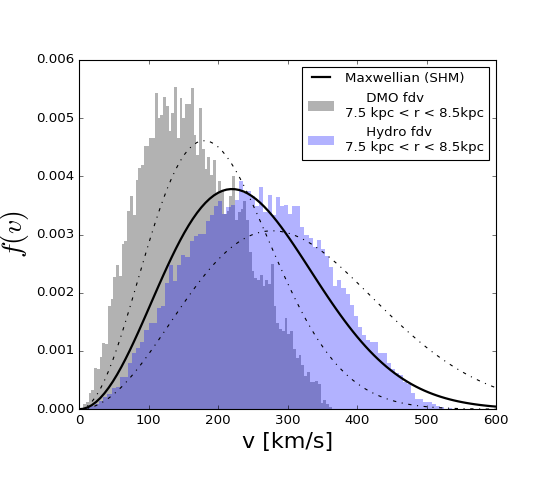

In [369]:

fig, ax = plt.subplots(figsize=[7,6])
plt.tight_layout(pad=4)
v= np.linspace(0,600,100)
ax.set_xlabel("v [km/s]",fontsize=20)
ax.set_ylabel(r"$f(v)$",fontsize=25)

ax.plot(v,maxw,"k",lw=2,label="Maxwellian (SHM)")
ax.plot(v,maxw2,"k-.",alpha=1)
ax.plot(v,maxw3,"k-.",alpha=1)

ax.bar((bin_dmo[:-1]+bin_dmo[1:])/2,fdv_dmo,width=bin_dmo[1]-bin_dmo[0],
       linewidth=0,color="k", alpha=0.3,label="     DMO fdv\n7.5 kpc < r < 8.5kpc")
ax.bar((bin_hyd[:-1]+bin_hyd[1:])/2,fdv_hyd,width=bin_hyd[1]-bin_hyd[0],
       linewidth=0,color="b", alpha=0.3,label="     Hydro fdv\n7.5 kpc < r < 8.5kpc")
legend = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=12)
frame = legend.get_frame()